# Predictive Maintenance

## Context

Machine failure is said to occur in equipment if the equipment underperforms partially or entirely or stops functioning the way it was designed to perform.
Machine failure impacts production work significantly. Machine failures can lead to unplanned downtime and repair costs, productivity losses, health and safety implications, and impact on the production and delivery of services. Its effect can have a lasting impact ultimately on the company's reputation. The cost of machine repairs is usually higher than it would have been had preventive maintenance been undertaken. Unplanned downtime can prevent the company from meeting its production demands to its clients and customers. A machine may not be able to perform its functions either fully or partially. Underperformance can create products that do not meet set quality criteria. Apart from the economic effects on the company's bottom line and reputation, machine failure can also have health and safety implications for the workers and expose the company to legal risks.

## Objective
- To identify the major causes of machine failures and prevent unplanned downtime, productivity losses, increased repair costs, impact on production and delivery of services, health and safety implications and company reputation.

- Develop a model that can predict machine failure to enable preventive and predictive maintenance.

- Preserve the equipment's service life and value during the equipment's design life.

- Provide insights to the company's maintenance department on the timely applications of maintenance measures to prevent downtimes, productivity losses, increased repair costs, and any adverse impact on production.

## Importing the necessary libraries

In [2]:
#import the required libraries
import pandas as pd
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from keras.layers import LSTM, Dense,Flatten
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import exists
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping

# To build model for prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
)

#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# To tune different models
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Bayesian Optimisation
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
import hyperopt
from hyperopt import fmin
import ast

## Load the data

In [3]:
#Load the data and store it
data = pd.read_csv('/content/drive/MyDrive/Imperial College Data Science/Portfolio Project/ai4i2020.csv')

## Data Overview

In [4]:
# Display the dimension of the data
print("The shape of the data is",data.shape)

# Print the number of rows and columns.
print(f"That is, there are {data.shape[0]} rows and {data.shape[1]} columns in the DataFrame.")

The shape of the data is (10000, 14)
That is, there are 10000 rows and 14 columns in the DataFrame.


In [5]:
# Check some random observations in the data.
data.sample(n=10, random_state=1)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9953,9954,L57133,L,298.1,307.8,1565,35.3,119,0,0,0,0,0,0
3850,3851,M18710,M,302.3,311.0,1421,41.3,182,0,0,0,0,0,0
4962,4963,M19822,M,304.0,312.7,1456,51.2,160,0,0,0,0,0,0
3886,3887,L51066,L,302.4,311.3,1392,50.5,51,0,0,0,0,0,0
5437,5438,M20297,M,302.9,312.6,1394,46.4,82,0,0,0,0,0,0
8517,8518,M23377,M,298.3,309.6,1469,54.8,191,0,0,0,0,0,0
2041,2042,L49221,L,299.1,308.9,1680,27.2,110,0,0,0,0,0,0
1989,1990,L49169,L,298.2,307.9,1785,23.4,181,0,0,0,0,0,0
1933,1934,L49113,L,298.1,308.0,1638,35.1,38,0,0,0,0,0,0
9984,9985,H39398,H,298.7,308.4,1432,42.8,197,0,0,0,0,0,0


In [6]:
# Copy the dataset into a new dataframe and check.
df = data.copy()
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


Observations:
- There are 10,000 instances and 14 columns in the dataset.
- The data in each row corresponds to UDI (Unique Identifier), Product ID, Product Type, Air Temperature [K], Process Temperature [K], Rotational Speed [rpm], Torque [Nm], Tool wear [min], Machine failure, TWF (Tool Wear Failure), HDF (Heat Dissipation Failure), PWF (Power Faiure), OSF (Overstrain Failure), RNF (Random Failure).

In [7]:
# print the summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

Observations:

- There are no null observations in the dataset
- The dataset contains 14 columns: two of object type (Product ID and Type), three of float type (Air Temperature, Process Temperature and Torque), and nine of integer type (UDI, Rotational Speed, Tool wear, Machine Failure, TWF, HDF, PWF, OSF, and RNF.
- Total memory usage is 1.1MB.

In [8]:
# check for missing values
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Observations:
- There are no null observations.

In [9]:
# check if there are any duplicates across any rows in the entries
df.duplicated().sum()

0

Observations:
- There are no duplicate entries in the dataset.

In [10]:
#check that the product IDs are not duplicated.
df['Product ID'].nunique()

10000

Observations:
- There are 10,000 unique products in the dataset.

In [11]:
#check that the product IDs are not duplicated.
df['Type'].nunique()

3

Observations:
- There are 3 types of products in the dataset. These are Low, Medium and High.


In [12]:
#show a summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


Observations:
- 50% of the recorded Air Temperature are greater than 300.1K.
- 50% of the recorded Process temperature are greater than 310.1K.
- 75% of the recorded Torque in the machine is greater that 33.2Nm.
- Most of the machine parts failed after 53 minutes.

## Exploratory Data Analysis

### Univariate Analysis

In [13]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

#### Air Temperature [K]

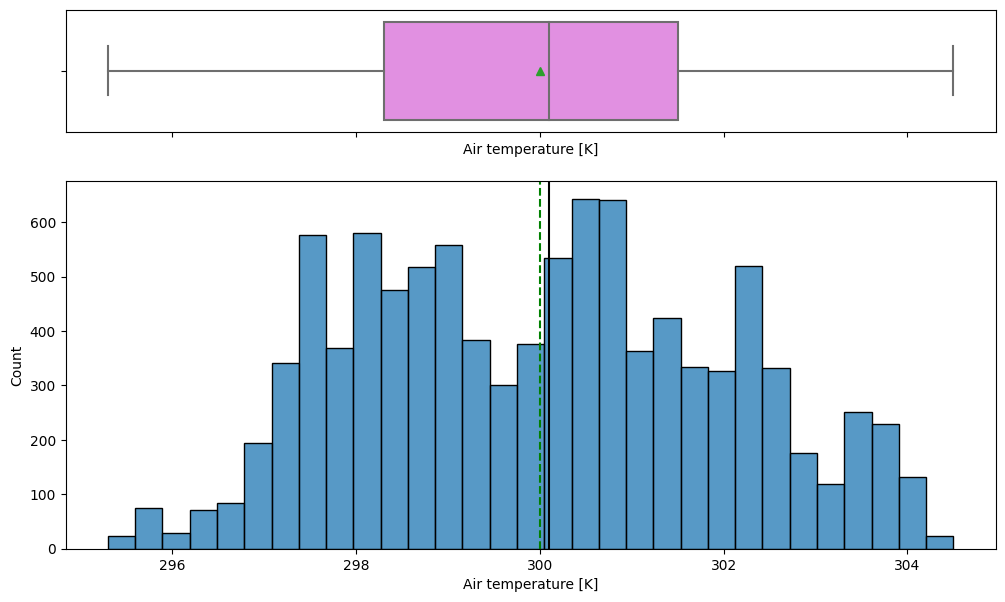

In [14]:
# create histogram and boxplot for Air temperature [K]
histogram_boxplot(df, 'Air temperature [K]')

Observations:
- The distribution of Air Temperature is left-skewed.
- Most of the recorded Air Temperature are between 298K and 302K and there exist some outliers below 296K.

#### Process Temperature

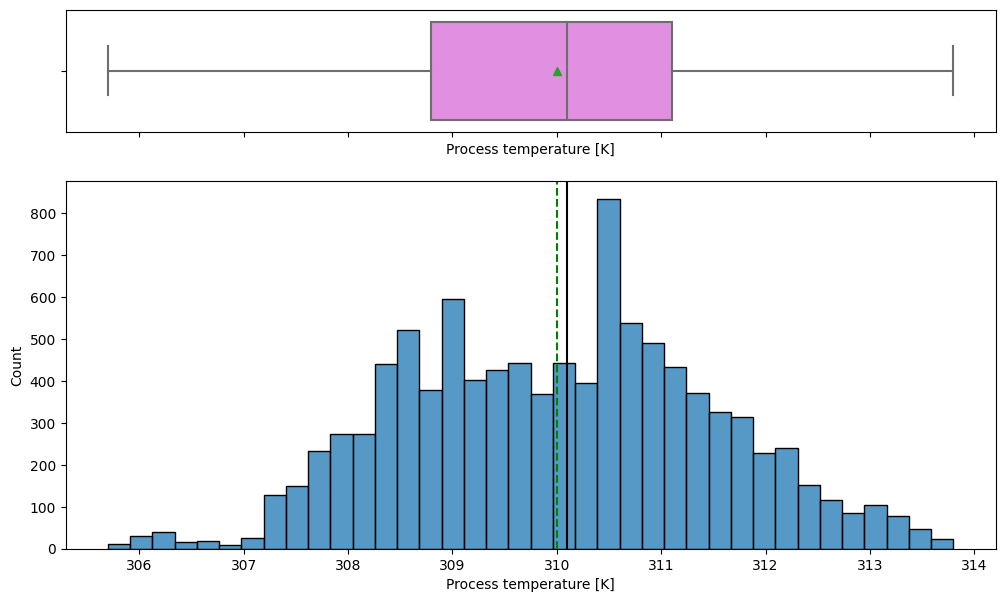

In [15]:
# create histogram and boxplot for Process temperature [K]
histogram_boxplot(df, 'Process temperature [K]')

Observations:
- The distribution of the Process Temperature is left-skewed.
- There are no outliers in the distribution.

#### Rotational Speed [rpm]

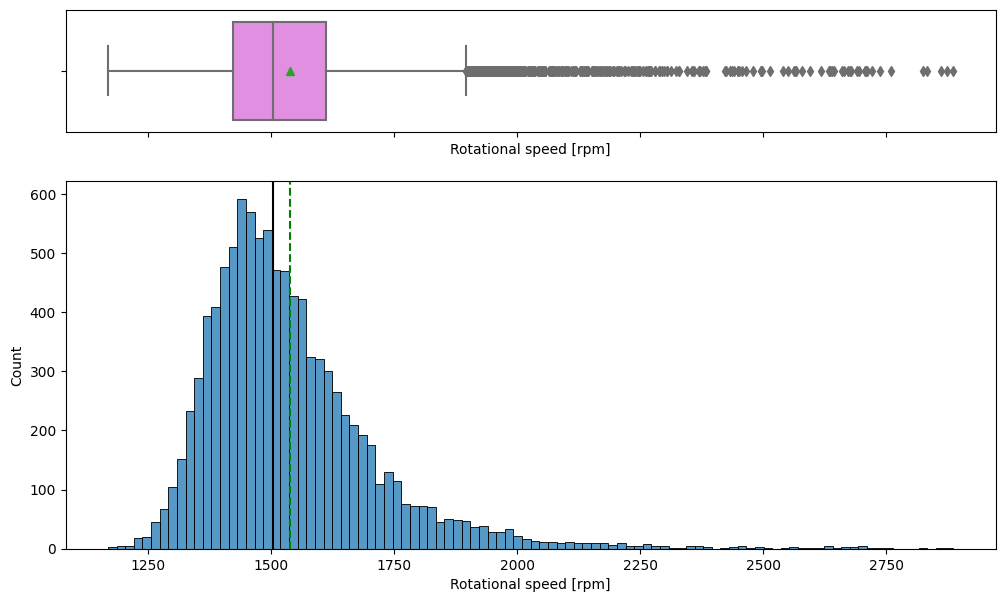

In [16]:
# create histogram and boxplot for Rotational speed [rpm]
histogram_boxplot(df, 'Rotational speed [rpm]')

Observations:
- The distribution of the Rotational Speed is right-skewed.
- There are outliers beyond 2000 rpm.
- Most of the recorded data is between 1250 rpm and 1750 rpm.

#### Torque [Nm]

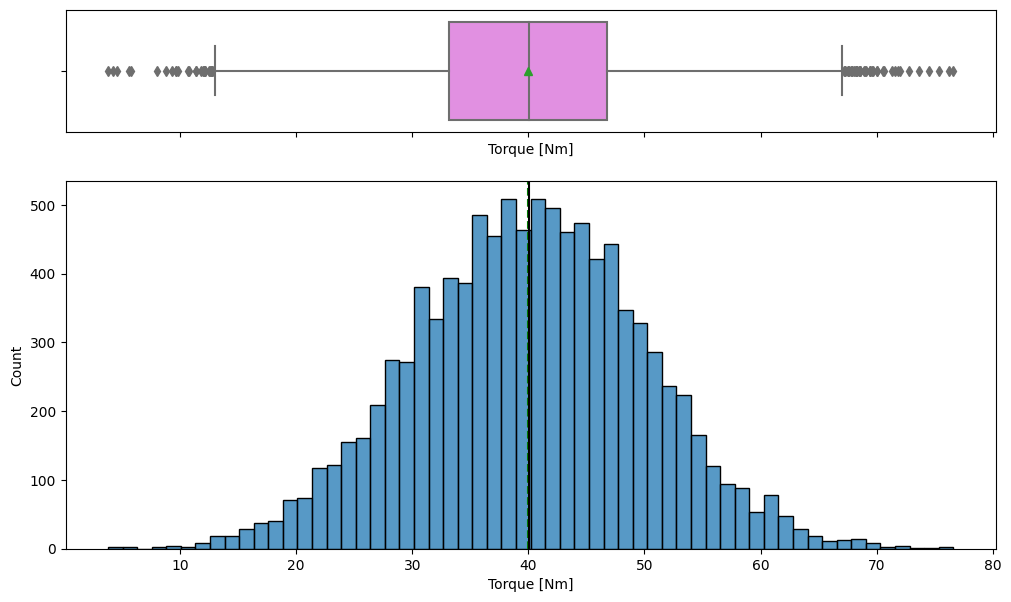

In [17]:
# create histogram and boxplot Torque [Nm]
histogram_boxplot(df, 'Torque [Nm]')

Observations:
- The distribution of Torque is symmetric.
- There exist outliers below 10 Nm and beyond 70 Nm.

#### Tool Wear [min]

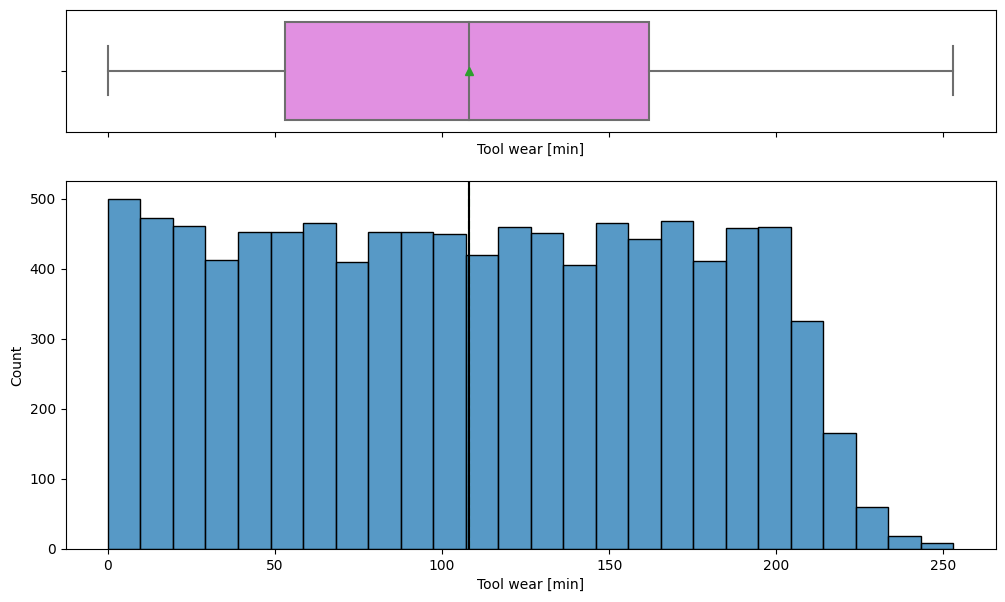

In [18]:
# create histogram and boxplot Tool wear [min]
histogram_boxplot(df, 'Tool wear [min]')


Observations:
- The distribution for Tool wear is almost uniform.
- The mean and median are equal.

#### Write a function to to plot the barplots.

In [19]:
# function to create labeled barplots


def labeled_barplot(df, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(df[feature])  # length of the column
    count = df[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="Paired",
        order=df[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Product Types

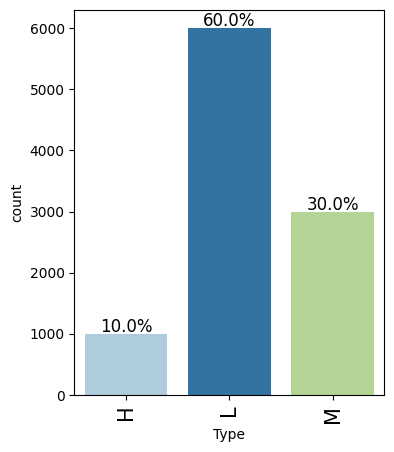

H - High Quality, M - Medium Quality, L - Low Quality


In [20]:
#Visualise the distribution of product types
labeled_barplot(df, 'Type', perc=True)
print("H - High Quality, M - Medium Quality, L - Low Quality")

Observations:
- The machine processed mostly low quality products at 60%.
- The least processed products are of high quality at 10%.
- Processing only low quality products with the machine increases the machine's life span.

#### Machine Failures

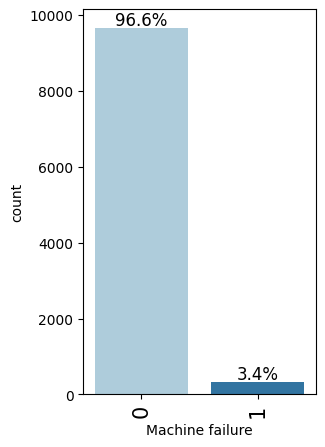

0 - No Failure, 1 - Failure


In [21]:
#Visualise the distribution of Machine failure
labeled_barplot(df, 'Machine failure', perc=True)
print("0 - No Failure, 1 - Failure")

Observations:
- Only 3.4% of the entries did the machine fail which is the class of interest.
- This means that the dataset is highly imbalanced.

#### Tool Wear Failures

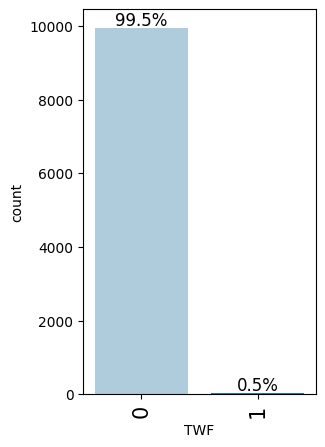

0 - No Failure, 1 - Failure


In [22]:
 #Visualise the distribution of TWF
labeled_barplot(df, 'TWF', perc=True)
print("0 - No Failure, 1 - Failure")

Observations:
- Tool Wear Failure only occurred in 0.5% entries.

#### Heat Dissipation Failure

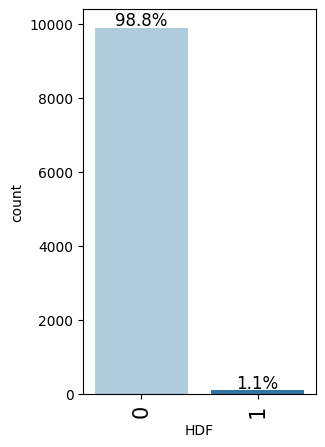

0 - No Failure, 1 - Failure


In [23]:
#Visualise the distribution of HDF
labeled_barplot(df, 'HDF', perc=True)
print("0 - No Failure, 1 - Failure")

Observations:
- Heat Dissipation Failure (HDF) occurs 1.1% of the data. We would see if all the HDF led to machine failure.

#### Power Failures

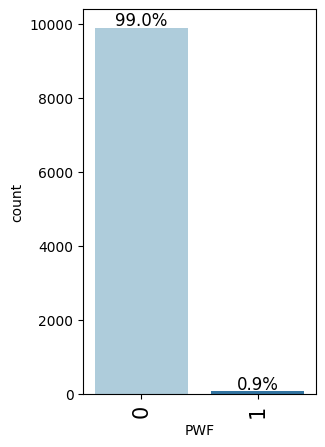

0 - No Failure, 1 - Failure


In [24]:
#Visualise the distribution of PWF
labeled_barplot(df, 'PWF', perc=True)
print("0 - No Failure, 1 - Failure")

Observations:
- Power failure occurs in 0.9% of the entries. We would see how many of the Power failures also caused machine failure.

#### Overstrain Failure

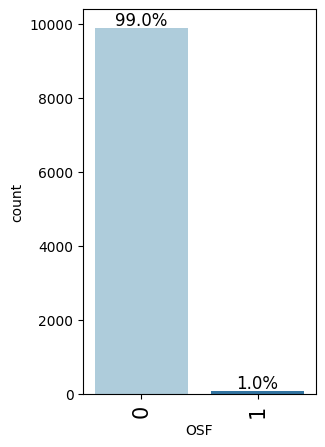

0 - No Failure, 1 - Failure


In [25]:
#Visualise the distribution of OSF
labeled_barplot(df, 'OSF', perc=True)
print("0 - No Failure, 1 - Failure")

Observations:
- There are just 1% of overstrain failures.

#### Random Failures


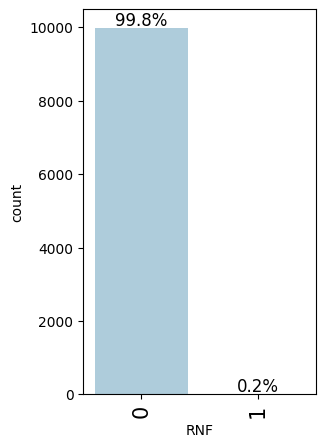

0 - No Failure, 1 - Failure


In [26]:
#Visualise the distribution of RNF
labeled_barplot(df, 'RNF', perc=True)
print("0 - No Failure, 1 - Failure")

Observations:
- There are only 0.2% of random failures. We would see how many of these of random failures led to machine failures.

### Bivariate Analysis

#### Correlation Plot of the dataset

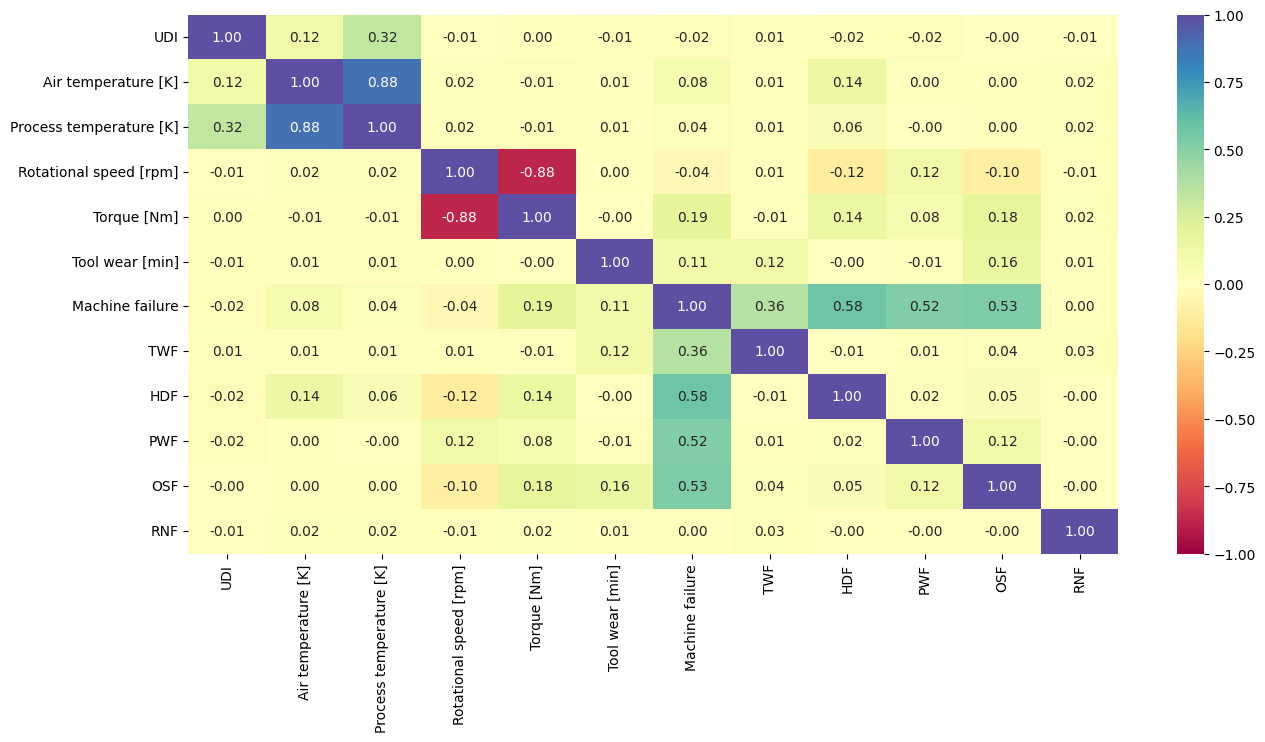

In [27]:
# Visualise the correlation among the numerical variables in the dataset
plt.figure(figsize=(15, 7))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(
    numeric_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

Observations:
- As the Rotational Speed increases the Torque reduces.
- HDF has the highest correlation with machine failure amongst all the failure modes.
- Process Temperature and Air Temperature are highly correlated. This correlation may affect regression.
- Machine failure has no correlation with Process Temperature or Air Temperature.

#### Frequency of Failure Modes

TWF     46
HDF    115
PWF     95
OSF     98
RNF     19
dtype: int64


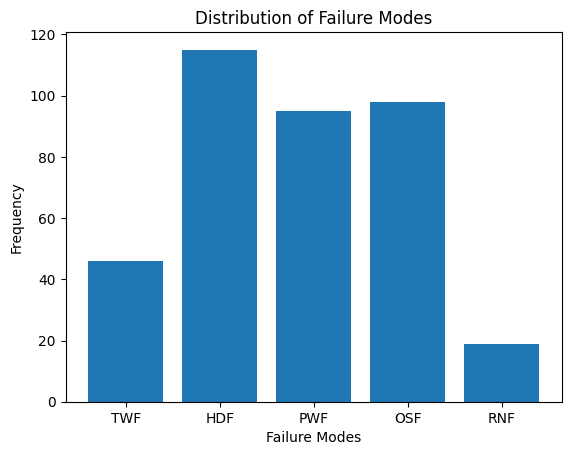

In [28]:
# Create a dataframe of the failure modes
df_failure_modes = df[['TWF','HDF', 'PWF', 'OSF','RNF']].sum()
print(df_failure_modes)

categories = ['TWF','HDF', 'PWF', 'OSF','RNF']
# Create bar plot
plt.bar(categories, df_failure_modes)

# Add title and labels
plt.title('Distribution of Failure Modes')
plt.xlabel('Failure Modes')
plt.ylabel('Frequency')

# Show the plot
plt.show()


Observations:
- Heat Dissipation Failure (HDF) occurs the most of all the failure modes followed by overstrain failure (OSF).
- The least occurring failure is Random Failure (RNF).

#### Count the combination of failure modes.

In [29]:
# Count the combinations of failure modes.
df_counts = df[['TWF','HDF', 'PWF', 'OSF','RNF']].value_counts().reset_index()
df_counts.columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Count']
df_counts




,TWF,HDF,PWF,OSF,RNF,Count
0,0,0,0,0,0,9652
1,0,1,0,0,0,106
2,0,0,1,0,0,80
3,0,0,0,1,0,78
4,1,0,0,0,0,42
5,0,0,0,0,1,18
6,0,0,1,1,0,11
7,0,1,0,1,0,6
8,0,1,1,0,0,3
9,1,0,0,1,0,2


Observations:
- There are a total of 9,652 observations when no failures occurred.
- Let's go further and see which failure modes actually led to failures and their combinations.

#### Make a dataframe of machine failures occurring.

In [30]:
#show the dataframe for only machine failures that occurred
df_machine_failure_1 = df[df['Machine failure']==1]
df_machine_failure_1

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
9764,9765,L56944,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
9822,9823,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
9830,9831,L57010,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


#### Count the combination of failure modes for machine failures.

In [31]:
#show a dataframe of combinations only failure modes that caused machine failure
df_machine_failure_1_counts = df_machine_failure_1[['TWF','HDF', 'PWF', 'OSF','RNF']].value_counts().reset_index()
df_machine_failure_1_counts.columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Count']
df_machine_failure_1_counts

,TWF,HDF,PWF,OSF,RNF,Count
0,0,1,0,0,0,106
1,0,0,1,0,0,80
2,0,0,0,1,0,78
3,1,0,0,0,0,42
4,0,0,1,1,0,11
5,0,0,0,0,0,9
6,0,1,0,1,0,6
7,0,1,1,0,0,3
8,1,0,0,1,0,2
9,1,0,0,0,1,1


Observations:
- There are a total of 9 combinations of failures which occurred.
- There are 9 cases when machine failures occurred without any failure mode being triggered.
- The combination of PWF and OSF resulted in machine failures.

#### Group the machine failures according to the failure modes.

In [32]:
# show a table for the sum of failures modes grouped by machine failures.
grouped_df = df[['Machine failure','TWF','HDF', 'PWF', 'OSF','RNF']]
grouped_df = df.groupby('Machine failure')['TWF','HDF', 'PWF', 'OSF','RNF'].sum()
grouped_df

<ipython-input-32-b7f167aa8656>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df.groupby('Machine failure')['TWF','HDF', 'PWF', 'OSF','RNF'].sum()


,TWF,HDF,PWF,OSF,RNF
Machine failure,,,,,
0,0,0,0,0,18
1,46,115,95,98,1


Observations:
- The HDF resulted in more machine failures than any other failure modes followed by the OSF while the RNF resulted in the least machine failures.

#### Time series of the machine properties.

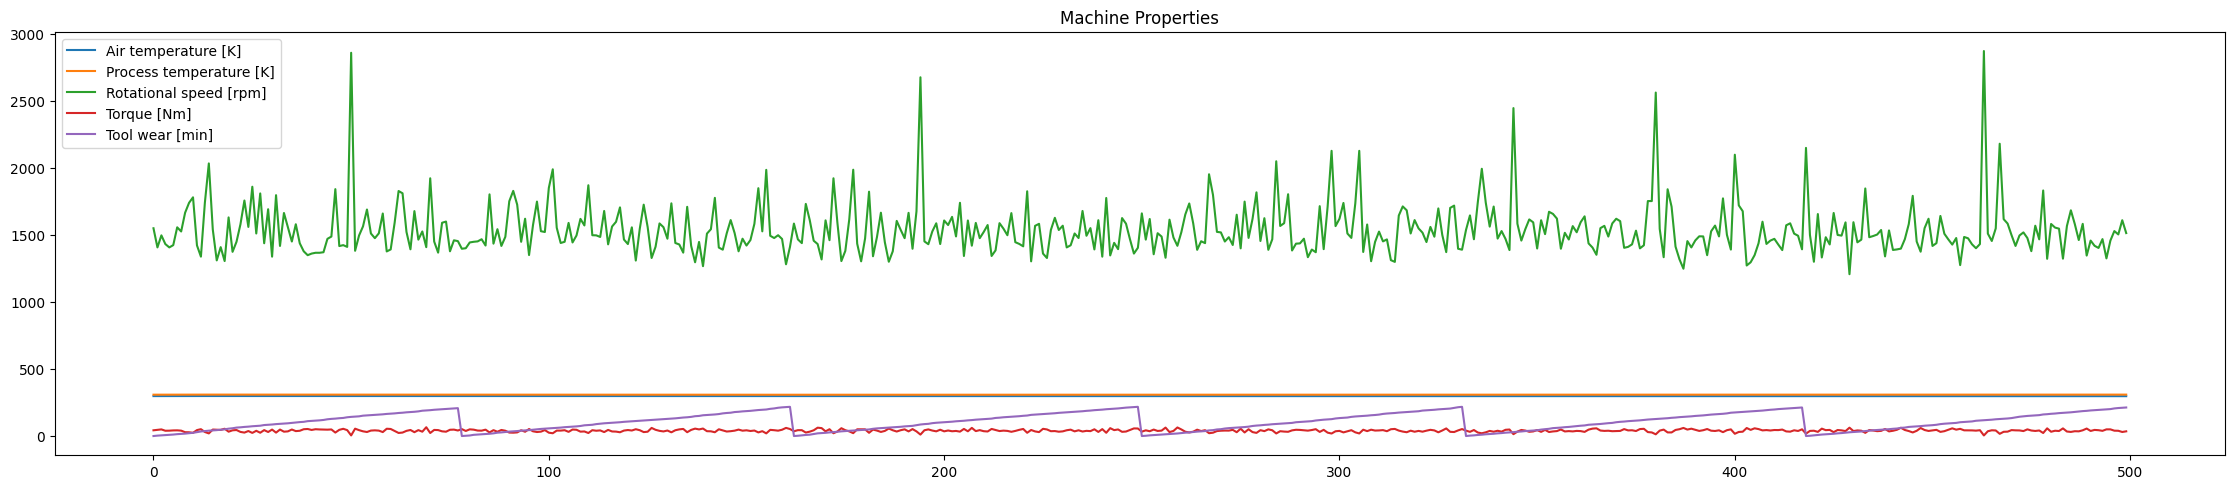

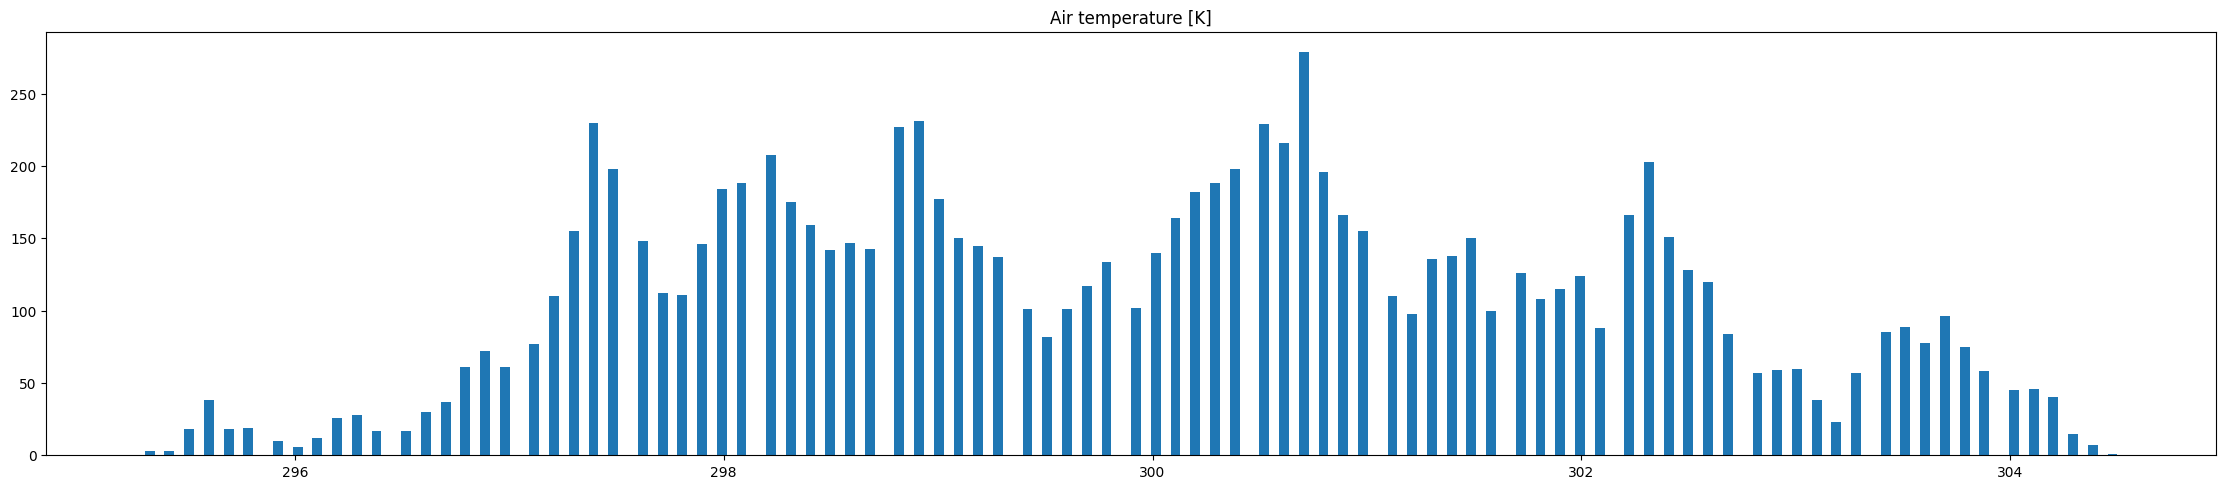

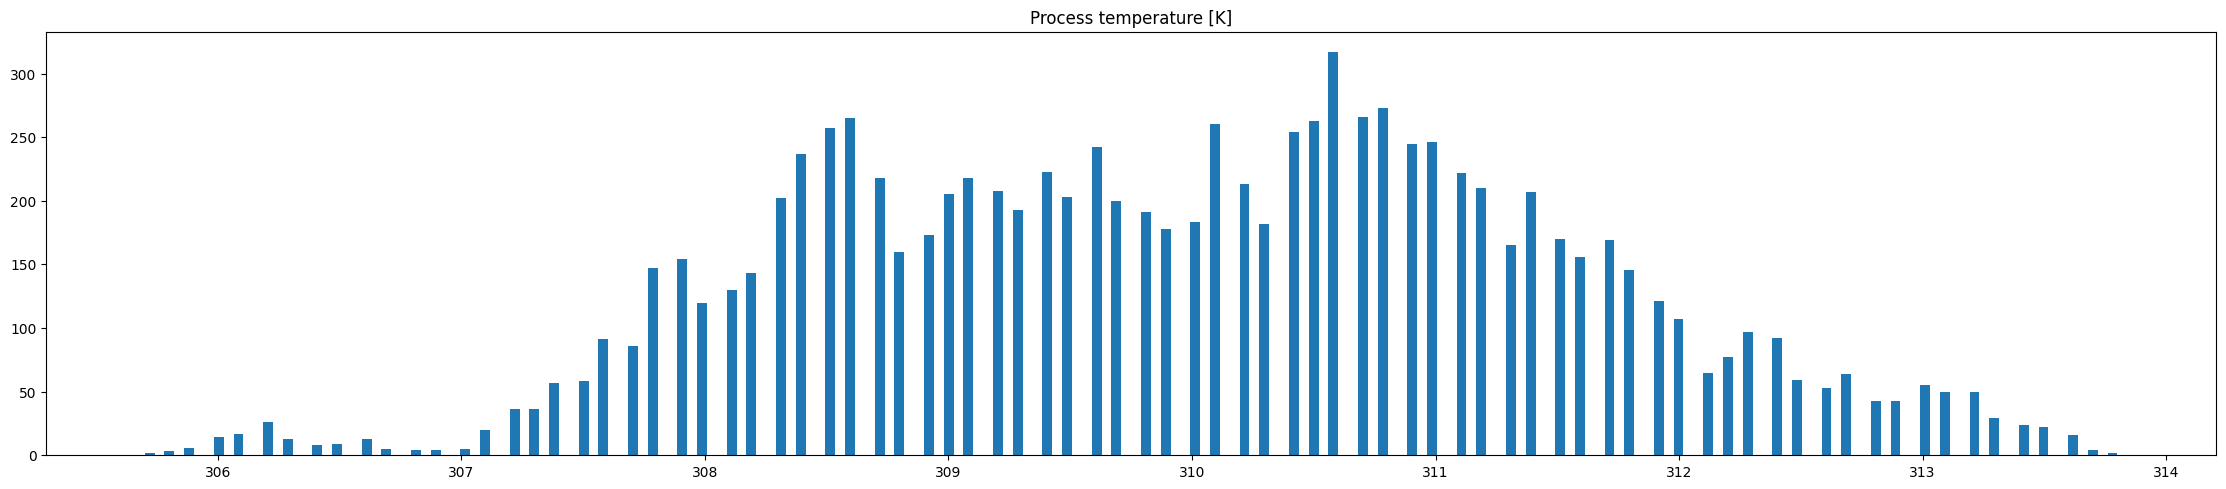

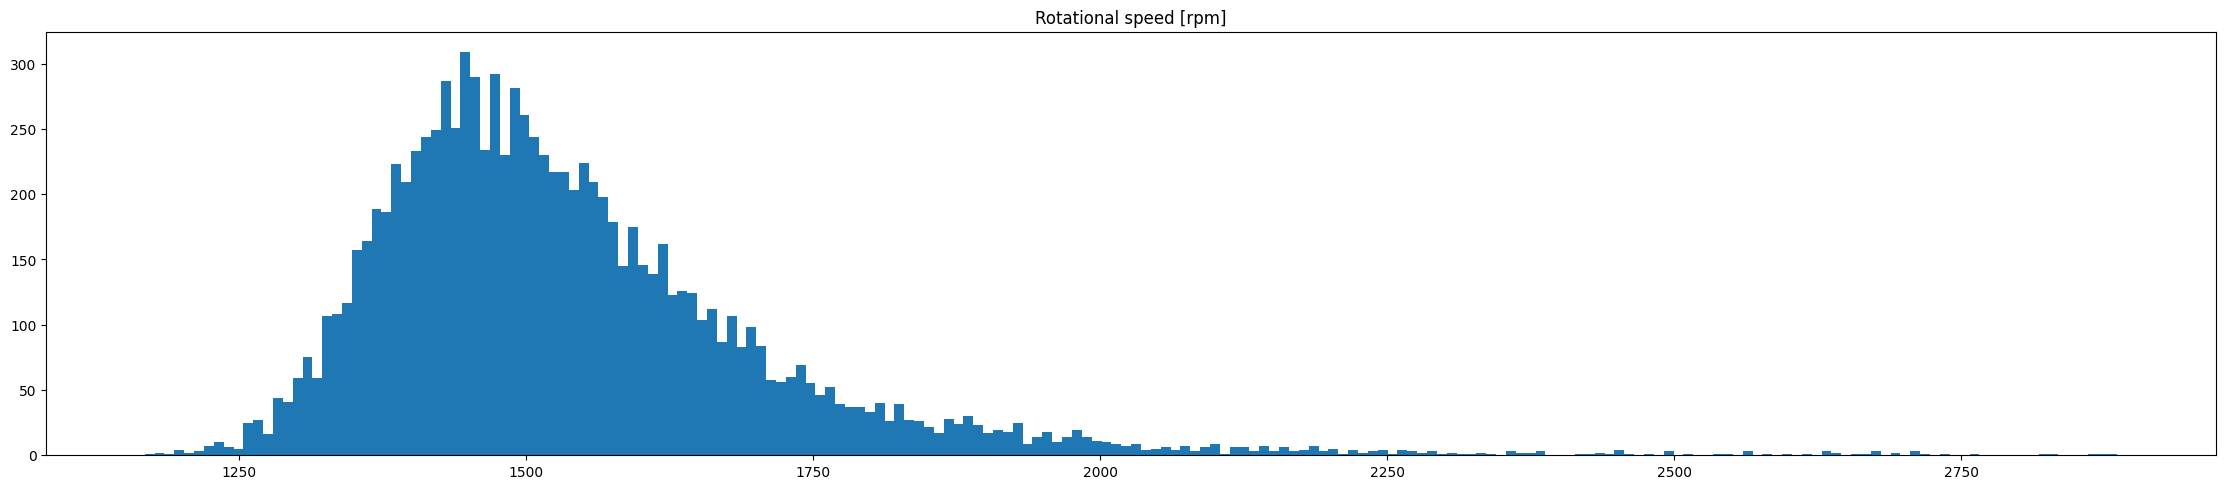

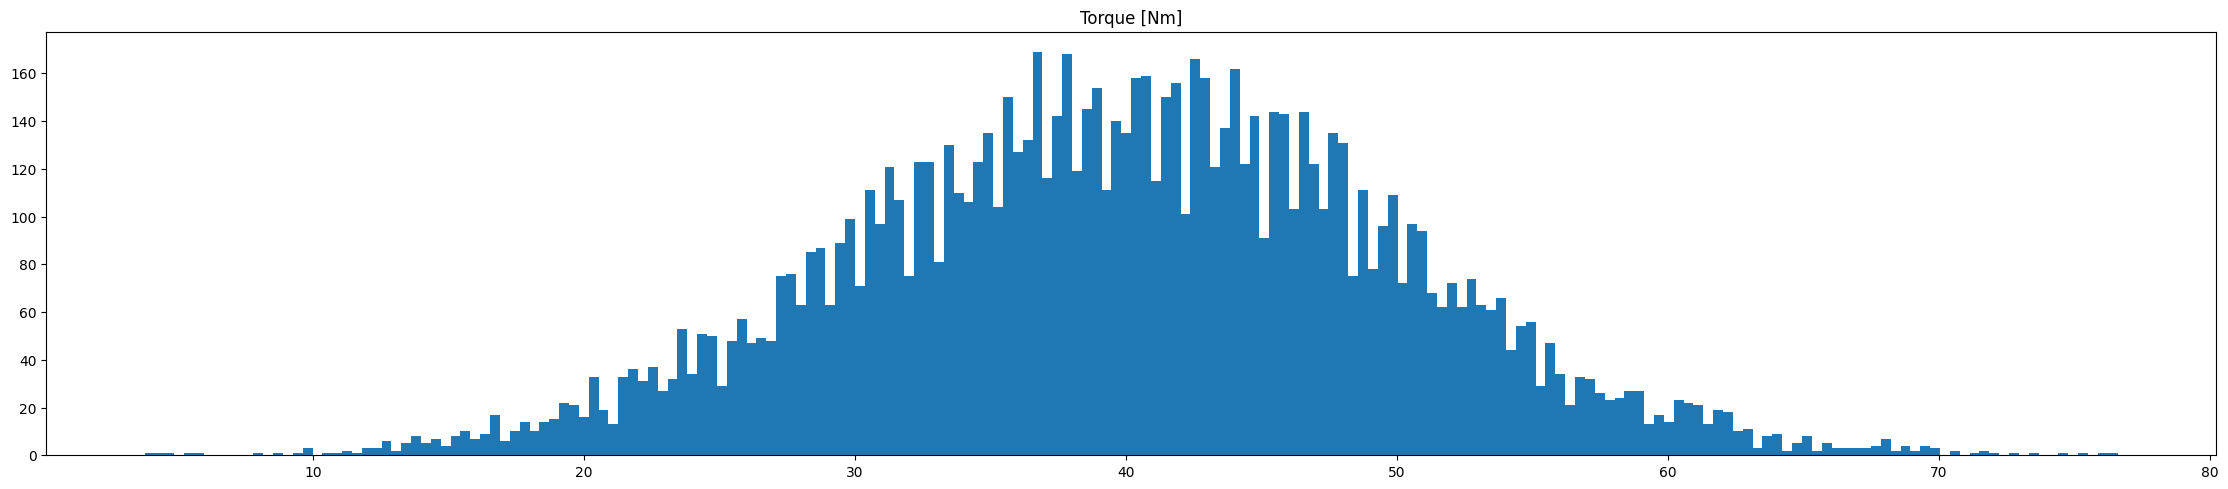

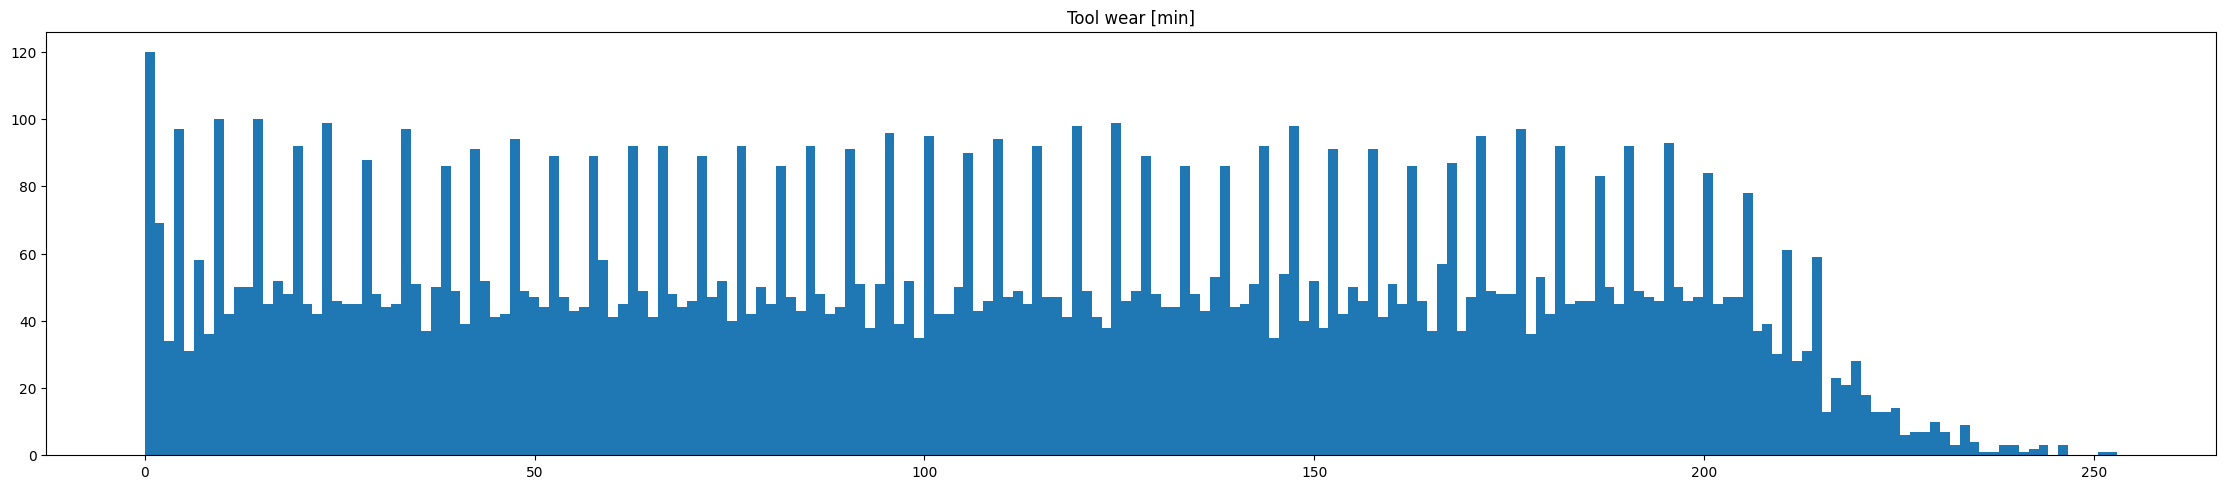

In [33]:
# plot the time series of the machine properties.
machine_prop = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']
results = df[machine_prop].head(500)

plt.rcParams["figure.figsize"] = (28,5.5)

for prop in machine_prop:
   plt.plot(results[prop], label=prop)
plt.title('Machine Properties')
plt.legend()
plt.show()

columns=[column for column in df.columns if column in machine_prop]
for column in columns:
    plt.hist(df[column],bins=200)
    plt.title(column)
    plt.show()

Observations:
- In the machine properties plot, the Tool Wear follows a zig-zag pattern which shows that as times (minutes) goes the wear machine parts increases but drops when the machine part is replaced.
-The Air Temperature and Process Temperature are steady.
- The Rotational speed and Torque exhibit an unsteady pattern.

## Build the models

### Build the LSTM Neutral Network

#### Data Preprocessing for Neutral Network.

In [34]:
# Make machine failure the last column.
df['Machine failure_Moved'] = df['Machine failure']

# drop the identifier columns and the duplicate of Machine failure
df.drop(['Machine failure', 'UDI', 'Product ID', 'Type'],axis = 1, inplace = True)

#rename the machine column
df.rename(columns = {'Machine failure_Moved':'label'}, inplace = True)

#make a list of column names
X_columns=[x for x in df.columns if x!='label']

# separate the dependent and independent variables
y_LSTM = df['label']
X_LSTM = df[X_columns]


In [35]:
# Split the dataset into train, validation and test sets.
X_trainval, X_test_LSTM, y_trainval, y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size=0.2, random_state=42)
X_train_LSTM, X_val_LSTM, y_train_LSTM, y_val_LSTM = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

#### Build the LSTM network on the original dataset (without over- or under- sampling)

In [36]:
# build the LSTM model.
look_back=1
num_labels = y_train_LSTM.nunique()
model = Sequential()
features=len(X_columns)
model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
model.add(LSTM(units = 50))
model.add(Flatten())
model.add(Dense(num_labels,activation='sigmoid'))
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
y_train_LSTM_1 = y_train_LSTM.copy() # make a copy of the train set
y_train_LSTM_1 = pd.get_dummies(y_train_LSTM_1) # One-hot encode the target column

Train the model
Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0089 - accuracy: 0.9988
Epoch 2/200
1/1 [==============================] - 0s 134ms/step - loss: 0.3195 - accuracy: 0.8662
Epoch 3/200
1/1 [==============================] - 0s 132ms/step - loss: 0.0116 - accuracy: 0.9977
Epoch 4/200
1/1 [==============================] - 0s 137ms/step - loss: 0.1057 - accuracy: 0.9655
Epoch 5/200
1/1 [==============================] - 0s 154ms/step - loss: 0.0910 - accuracy: 0.9755
Epoch 6/200
1/1 [==============================] - 0s 132ms/step - loss: 0.0841 - accuracy: 0.9742
Epoch 7/200
1/1 [==============================] - 0s 138ms/step - loss: 0.0178 - accuracy: 0.9953
Epoch 8/200
1/1 [==============================] - 0s 147ms/step - loss: 0.0156 - accuracy: 0.9965
Epoch 9/200
1/1 [==============================] - 0s 138ms/step - loss: 0.0186 - accuracy: 0.9953
Epoch 10/200
1/1 [==============================] - 0s 131ms/step - loss: 0.0159 - accuracy: 0.9

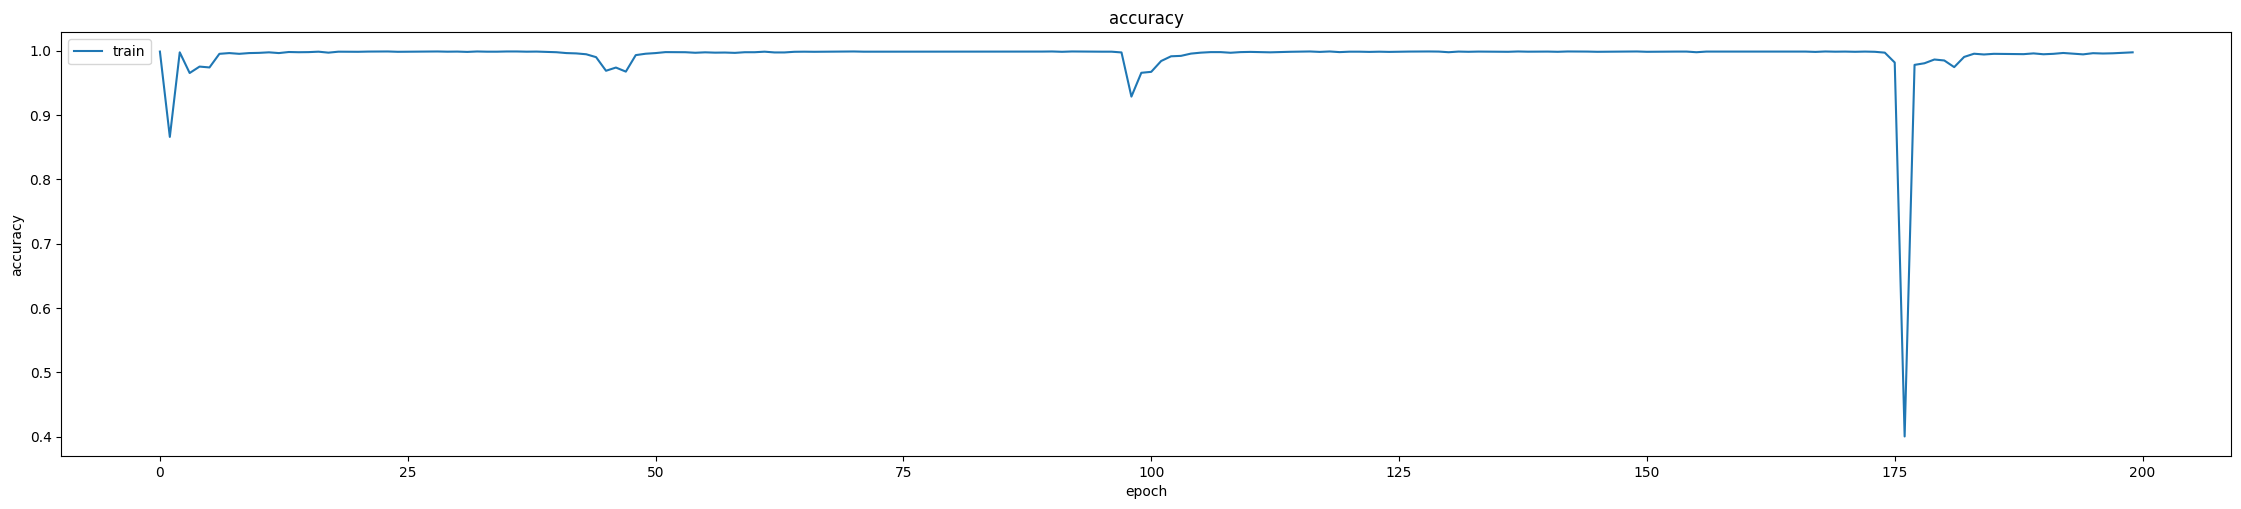

,loss,accuracy
0,0.007969,0.998667
1,0.008092,0.998833
2,0.008106,0.999000
3,0.008115,0.999000
4,0.008128,0.999000


In [38]:
#calculate the accuracy scores and plot the accuracy scores over the epochs and train the model on imbalanced dataset
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

print ("Train the model")
length=len(X_train_LSTM)
path_to_file="/content/drive/MyDrive/Imperial College Data Science/Portfolio Project/Model Weights/model_LSTM/my_model.h5"

early_stopping = EarlyStopping(monitor='accuracy', patience=50)
file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
X2 = np.asarray(X_train_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y2 = np.asarray(y_train_LSTM_1).astype(np.float32)
#history=model.fit(X2,y2,batch_size=len(X),epochs=100,verbose=1,callbacks=[early_stopping])
history=model.fit(X2,y2,batch_size=len(X_train_LSTM),epochs=200,verbose=1)
model.save_weights(path_to_file) # can give whole path to save model
plotHistory(history)

# make a dataframe losses and accuracies
history_df = pd.DataFrame(history.history)

#show the top 5 accuracies
history_df.sort_values('loss', ascending = True, inplace = True)
history_df.reset_index(inplace = True, drop = True)
history_df.head()

Observations:
- The performance on the train set is good.
- Since the dataset is imbalanced, try over- and under- sampling.

In [39]:
# calculate the AUC on the train set
y_train_LSTM_1 = y_train_LSTM.copy() # make a copy of the train set
y_train_LSTM_1 = pd.get_dummies(y_train_LSTM_1) # one-hot encode the validation set

# calculate the roc_auc score
X2 = np.asarray(X_train_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_original_train_data = roc_auc_score(y_train_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the train set for network built on original data", auc_original_train_data)

auc_original_train_data = pd.Series(auc_original_train_data)



188/188 [==============================] - 2s 3ms/step
The AUC of the train set for network built on original data 0.9915559677455184


In [40]:
# calculate the AUC on the validation set
y_val_LSTM_1 = y_val_LSTM.copy() # make a copy of the val set
y_val_LSTM_1 = pd.get_dummies(y_val_LSTM_1) # one-hot encode the validation set

# calculate the roc_auc score
X2 = np.asarray(X_val_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_original_val_data = roc_auc_score(y_val_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the validation set for network built on original data", auc_original_val_data)

auc_original_val_data = pd.Series(auc_original_val_data)


63/63 [==============================] - 0s 3ms/step
The AUC of the validation set for network built on original data 0.9954381443298969


In [41]:
# calculate the AUC on the test set
y_test_LSTM_1 = y_test_LSTM.copy() # make a copy of the test set
y_test_LSTM_1 = pd.get_dummies(y_test_LSTM_1) # one-hot encode the validation set

# calculate the roc_auc score
X2 = np.asarray(X_test_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_original_test_data = roc_auc_score(y_test_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the test set for network built on original data", auc_original_test_data)

auc_original_test_data = pd.Series(auc_original_test_data)


63/63 [==============================] - 0s 3ms/step
The AUC of the test set for network built on original data 0.9856737037005723


Observations:
- The model performs well without under- or over- sampling.

#### Undersampled dataset

In [42]:
# conduct undersampling because the dataset is imbalanced

print("Before UnderSampling, counts of label '1': {}".format(sum(y_LSTM == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_LSTM == 0)))


# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_LSTM_un, y_train_LSTM_un = rus.fit_resample(X_train_LSTM, y_train_LSTM)

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_LSTM_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_LSTM_un == 0)))


print("After UnderSampling, the shape of X_train_LSTM_un: {}".format(X_train_LSTM_un.shape))
print("After UnderSampling, the shape of y_train_LSTM_un: {} \n".format(y_train_LSTM_un.shape))


Before UnderSampling, counts of label '1': 339
Before UnderSampling, counts of label '0': 9661 

After UnderSampling, counts of label '1': 218
After UnderSampling, counts of label '0': 218 

After UnderSampling, the shape of X_train_LSTM_un: (436, 10)
After UnderSampling, the shape of y_train_LSTM_un: (436,) 



In [43]:
y_train_LSTM_un_1 = y_train_LSTM_un.copy()  # make a copy of the undersampled train set
y_train_LSTM_un_1= pd.get_dummies(y_train_LSTM_un_1) # One-hot encode the corresponding target column.

Train the model
Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 0.0717 - accuracy: 0.9839
Epoch 2/200
1/1 [==============================] - 0s 28ms/step - loss: 0.8392 - accuracy: 0.6261
Epoch 3/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0891 - accuracy: 0.9771
Epoch 4/200
1/1 [==============================] - 0s 30ms/step - loss: 0.4571 - accuracy: 0.8372
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - loss: 1.4322 - accuracy: 0.5528
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - loss: 0.3583 - accuracy: 0.8761
Epoch 7/200
1/1 [==============================] - 0s 28ms/step - loss: 0.2612 - accuracy: 0.8853
Epoch 8/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0872 - accuracy: 0.9794
Epoch 9/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0982 - accuracy: 0.9656
Epoch 10/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0698 - accuracy: 0.9817
Epoch

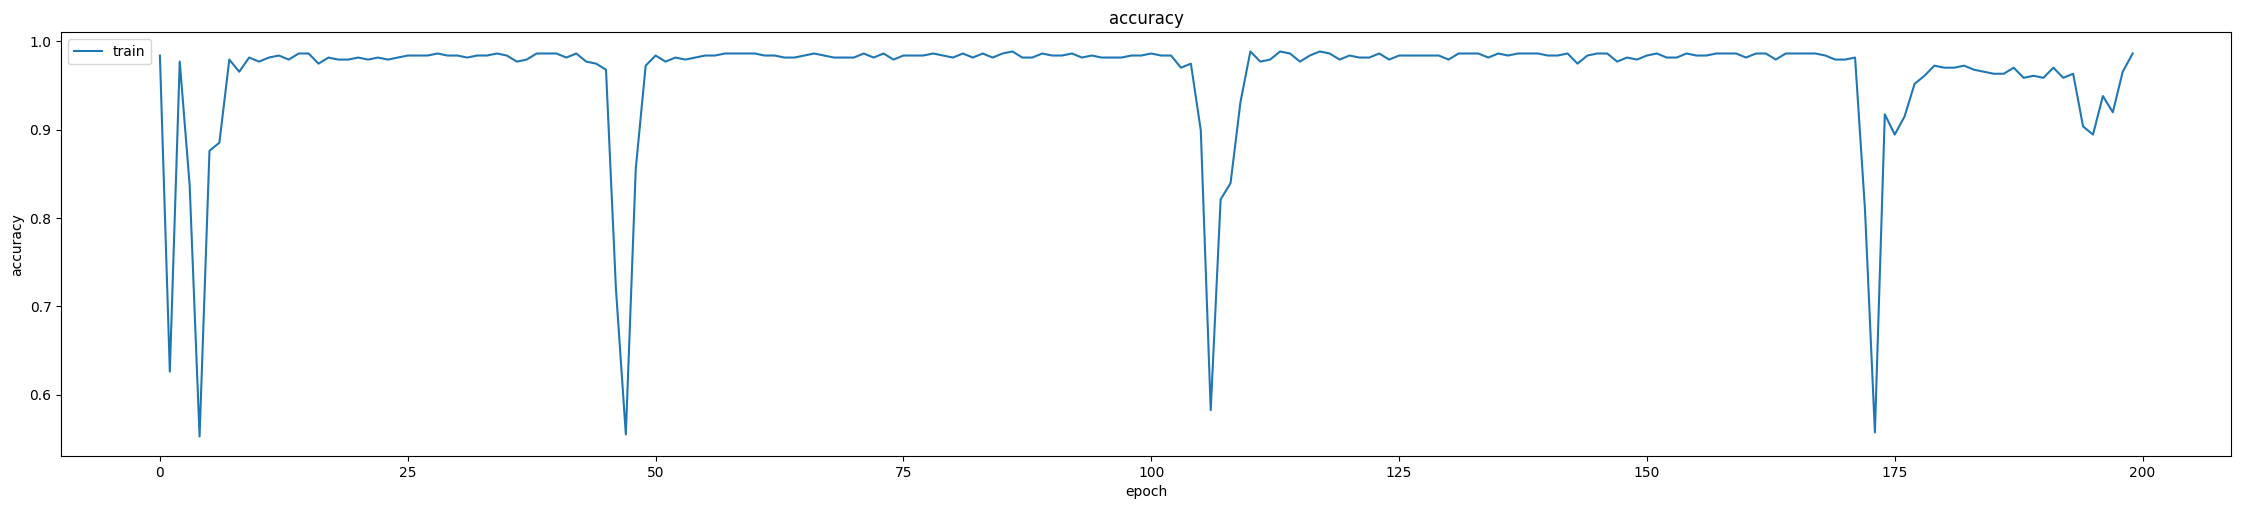

,loss,accuracy
0,0.051013,0.988532
1,0.051508,0.986239
2,0.051572,0.986239
3,0.052565,0.986239
4,0.053091,0.986239


In [44]:
# define a function to calculate the accuracy, plot the accuracy at each epoch and train the model on the undersampled dataset
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

print ("Train the model")
length=len(X_train_LSTM_un)
path_to_file="/content/drive/MyDrive/Imperial College Data Science/Portfolio Project/Model Weights/model_LSTM/my_model_un.h5"

early_stopping = EarlyStopping(monitor='accuracy', patience=50)
file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
X2 = np.asarray(X_train_LSTM_un).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y2 = np.asarray(y_train_LSTM_un_1).astype(np.float32)
#history=model.fit(X2,y2,batch_size=len(X),epochs=100,verbose=1,callbacks=[early_stopping])
history=model.fit(X2,y2,batch_size=len(X_train_LSTM_un),epochs=200,verbose=1)
model.save_weights(path_to_file) # can give whole path to save model
plotHistory(history)

#create a dataframe and sort according to highest accuracy
history_df = pd.DataFrame(history.history)

#show the top 5 accuracies
history_df.sort_values('loss', ascending = True, inplace = True)
history_df.reset_index(inplace = True, drop = True)
history_df.head()

Observations:
- From the graph, the accuracy seems unsteady.
- For the undersampled data, the accuracy drops slightly.

In [45]:
# calculate the roc_auc score
X2 = np.asarray(X_train_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_undersampled_train_data = roc_auc_score(y_train_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the train set for network built on undersampled data", auc_undersampled_train_data)

auc_undersampled_train_data = pd.Series(auc_undersampled_train_data)


188/188 [==============================] - 1s 4ms/step
The AUC of the train set for network built on undersampled data 0.994154589218676


In [46]:
# calculate the roc_auc score
X2 = np.asarray(X_val_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_undersampled_val_data = roc_auc_score(y_val_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the validation set for network built on undersampled data", auc_undersampled_val_data)

auc_undersampled_val_data = pd.Series(auc_undersampled_val_data)

63/63 [==============================] - 0s 4ms/step
The AUC of the validation set for network built on undersampled data 0.9961984536082473


In [47]:
# calculate the roc_auc score
X2 = np.asarray(X_test_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_undersampled_test_data = roc_auc_score(y_test_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the test set for network built on undersampled data", auc_undersampled_test_data)

auc_undersampled_test_data = pd.Series(auc_undersampled_test_data)

63/63 [==============================] - 0s 4ms/step
The AUC of the test set for network built on undersampled data 0.9827653260511164


Observations:
- The performance on the validation set drops slightly.
- Conduct further investigation using oversampled data.

#### Oversampled Dataset

In [48]:
# conduct oversampling because the dataset is imbalanced
print("Before OverSampling, counts of label '1': {}".format(sum(y_LSTM == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_LSTM == 0)))

# Initialize SMOTE
smote = SMOTE()

# Fit SMOTE on the training data
X_train_LSTM_ov, y_train_LSTM_ov = smote.fit_resample(X_train_LSTM, y_train_LSTM)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_LSTM_ov == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_LSTM_ov == 0)))


print("After OverSampling, the shape of X_train_LSTM: {}".format(X_train_LSTM_ov.shape))
print("After OverSampling, the shape of y_train_LSTM: {} \n".format(y_train_LSTM_ov.shape))

Before OverSampling, counts of label '1': 339
Before OverSampling, counts of label '0': 9661 

After OverSampling, counts of label '1': 5782
After OverSampling, counts of label '0': 5782 

After OverSampling, the shape of X_train_LSTM: (11564, 10)
After OverSampling, the shape of y_train_LSTM: (11564,) 



In [49]:
y_train_LSTM_ov_1 = y_train_LSTM_ov.copy() # make a copy of the oversampled train set
y_train_LSTM_ov_1= pd.get_dummies(y_train_LSTM_ov_1) # One-hot encode the corresponding target column.

Train the model
Epoch 1/200
1/1 [==============================] - 1s 521ms/step - loss: 0.1970 - accuracy: 0.9106
Epoch 2/200
1/1 [==============================] - 0s 494ms/step - loss: 0.1913 - accuracy: 0.9087
Epoch 3/200
1/1 [==============================] - 0s 453ms/step - loss: 0.1848 - accuracy: 0.9173
Epoch 4/200
1/1 [==============================] - 0s 472ms/step - loss: 0.1796 - accuracy: 0.9196
Epoch 5/200
1/1 [==============================] - 0s 382ms/step - loss: 0.1774 - accuracy: 0.9236
Epoch 6/200
1/1 [==============================] - 0s 299ms/step - loss: 0.1799 - accuracy: 0.9228
Epoch 7/200
1/1 [==============================] - 0s 292ms/step - loss: 0.1768 - accuracy: 0.9244
Epoch 8/200
1/1 [==============================] - 0s 282ms/step - loss: 0.1794 - accuracy: 0.9216
Epoch 9/200
1/1 [==============================] - 0s 277ms/step - loss: 0.1789 - accuracy: 0.9217
Epoch 10/200
1/1 [==============================] - 0s 263ms/step - loss: 0.1789 - accuracy: 

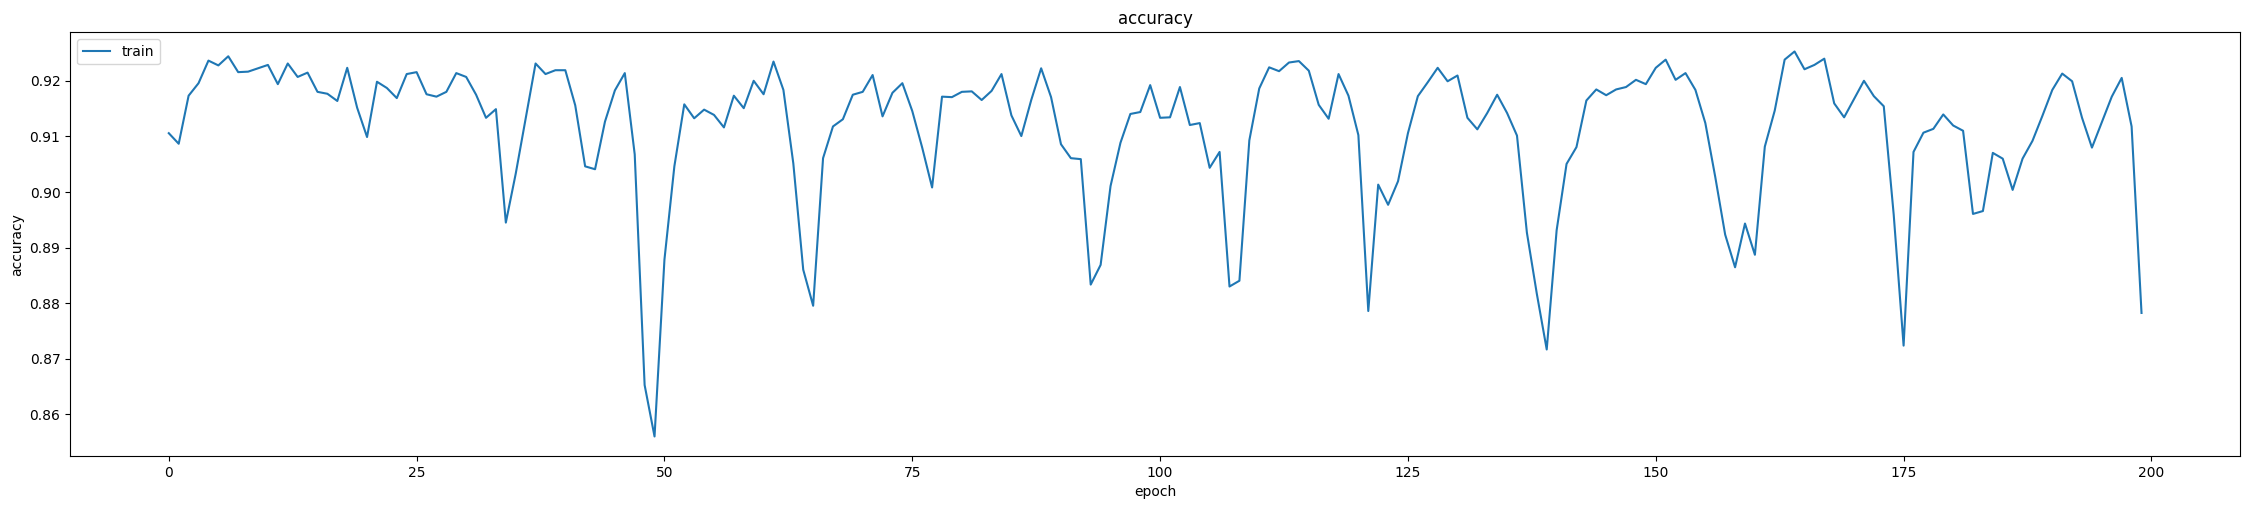

,loss,accuracy
0,0.174270,0.922345
1,0.176389,0.923815
2,0.176559,0.921913
3,0.176756,0.924421
4,0.177054,0.925285


In [50]:
# define a function to calculate the accuracy at each epoch, plot the accuracy and train the model
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

print ("Train the model")
length=len(X_train_LSTM_ov)
path_to_file="/content/drive/MyDrive/Imperial College Data Science/Portfolio Project/Model Weights/model_LSTM/my_model_ov.h5"

early_stopping = EarlyStopping(monitor='accuracy', patience=50)
file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
X2 = np.asarray(X_train_LSTM_ov).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y2 = np.asarray(y_train_LSTM_ov_1).astype(np.float32)
#history=model.fit(X2,y2,batch_size=len(X),epochs=100,verbose=1,callbacks=[early_stopping])
history=model.fit(X2,y2,batch_size=len(X_train_LSTM_ov),epochs=200,verbose=1)
model.save_weights(path_to_file) # can give whole path to save model
plotHistory(history)

#create a dataframe and sort according to highest accuracy
history_df = pd.DataFrame(history.history)

history_df.sort_values('loss', ascending = True, inplace = True)
history_df.reset_index(inplace = True, drop = True)
history_df.head()

Observations:
- From the graph, the accuracy looks unsteady.
- The accuracy drops significantly compared to the undersampled and original data.

In [51]:
# calculate the roc_auc score
X2 = np.asarray(X_train_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_oversampled_train_data = roc_auc_score(y_train_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the train set for network built on oversampled data", auc_oversampled_train_data)

auc_oversampled_train_data = pd.Series(auc_oversampled_train_data)

188/188 [==============================] - 1s 3ms/step
The AUC of the train set for network built on oversampled data 0.9900017929734481


In [52]:
# calculate the roc_auc score
X2 = np.asarray(X_val_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_oversampled_val_data = roc_auc_score(y_val_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the validation set for network built on oversampled data", auc_oversampled_val_data)

auc_oversampled_val_data = pd.Series(auc_oversampled_val_data)

63/63 [==============================] - 0s 5ms/step
The AUC of the validation set for network built on oversampled data 0.9899570446735395


In [53]:
# calculate the roc_auc score
X2 = np.asarray(X_test_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_oversampled_test_data = roc_auc_score(y_test_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the test set for network built on oversampled data", auc_oversampled_test_data)

auc_oversampled_test_data = pd.Series(auc_oversampled_test_data)

63/63 [==============================] - 0s 5ms/step
The AUC of the test set for network built on oversampled data 0.9792609000752458


Observations:
- The model trained on the oversampled dataset performs well as seen in auc score.

####Bayesian Optimisation

In [54]:
y_val_LSTM_ov_2 = y_val_LSTM.copy() # make a copy of the oversampled validation set
y_val_LSTM_ov_2= pd.get_dummies(y_val_LSTM_ov_2) # One-hot encode the corresponding target column.

In [55]:
N_FOLDS = 20
def objective(params, n_folds = N_FOLDS):
    """Objective function for LSTM Hyperparameter Optimization"""

    # Keep track of evals
    global ITERATION

    ITERATION += 1

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['units', 'units_2', 'units_3', 'epochs']:
        params[parameter_name] = int(params[parameter_name])

    start = timer()

    # Build the LSTM model
    look_back=1
    model = Sequential()
    features=len(X_columns)
    model.add(LSTM(units=params['units'], activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
    model.add(Dropout(0.2))
    model.add(LSTM(units=params['units_2'], activation='tanh', return_sequences=True))
    model.add(LSTM(units=params['units_3']))
    model.add(Flatten())
    model.add(Dense(num_labels,activation='sigmoid'))
    model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])

    # Perform n_folds cross validation
    X2 = np.asarray(X_train_LSTM_un).astype(np.float32)
    X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
    y2 = np.asarray(y_train_LSTM_un_1).astype(np.float32)

    X3 = np.asarray(X_val_LSTM).astype(np.float32)
    X3 = np.resize(X3,(X3.shape[0],1,X3.shape[1]))
    y3 = np.asarray(y_val_LSTM_ov_2).astype(np.float32)

    history = model.fit(X2, y2, epochs=params['epochs'], validation_data=(X3, y3))

    run_time = timer() - start

    # Extract the best score
    best_score = max(history.history['val_accuracy'])

    # Loss must be minimized
    loss = 1 - best_score

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, run_time])

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}


In [56]:
# Define the search space
space = {
    'units': hp.quniform('units', 50, 200, 1),
    'units_2': hp.quniform('units_2', 50, 200, 1),
    'units_3': hp.quniform('units_3', 50, 200, 1),
    'epochs': hp.quniform('epochs', 10, 100, 1),
}

# Sample from the space
x = sample(space)

x


{'epochs': 79.0, 'units': 168.0, 'units_2': 167.0, 'units_3': 86.0}

In [57]:
# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

In [58]:
import os
import csv

# Define directory and file
directory = 'results'
file = 'LSTM_trials.csv'

# Create directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Full path to your file
out_file = os.path.join(directory, file)

of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

In [59]:
# Perform the Bayesian Optimisation

%%capture

# Global variable
global  ITERATION

MAX_EVALS = 70

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.default_rng(50))

In [60]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.028500020503997803,
  'params': {'epochs': 50, 'units': 174, 'units_2': 110, 'units_3': 94},
  'iteration': 16,
  'train_time': 34.23658507599998,
  'status': 'ok'},
 {'loss': 0.028500020503997803,
  'params': {'epochs': 87, 'units': 79, 'units_2': 172, 'units_3': 76},
  'iteration': 68,
  'train_time': 52.367280114000096,
  'status': 'ok'}]

In [62]:
# store the results in a file
results = pd.read_csv('results/LSTM_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,train_time
0,0.0285,"{'epochs': 50, 'units': 174, 'units_2': 110, '...",16,34.236585
1,0.0285,"{'epochs': 87, 'units': 79, 'units_2': 172, 'u...",68,52.367280
2,0.0290,"{'epochs': 93, 'units': 86, 'units_2': 172, 'u...",69,58.528232
3,0.0290,"{'epochs': 72, 'units': 78, 'units_2': 51, 'un...",52,33.385306
4,0.0290,"{'epochs': 82, 'units': 92, 'units_2': 193, 'u...",66,51.505903


In [63]:
# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'epochs': 50, 'units': 174, 'units_2': 110, 'units_3': 94}

In [64]:
# Define the model using the Bayesian optimised units.
look_back=1
num_labels = y_train_LSTM.nunique()
features=len(X_columns)

model = Sequential()
model.add(LSTM(units=174, activation='tanh', return_sequences=True, input_shape=(look_back, features),dtype="float32"))
model.add(Dropout(0.2))
model.add(LSTM(units=110, activation='tanh', return_sequences=True))
model.add(LSTM(units=94))
model.add(Flatten())
model.add(Dense(num_labels,activation='sigmoid'))

# Compile the model
model.compile(optimizer="rmsprop", loss='categorical_crossentropy', metrics=['accuracy'])




In [65]:
y_train_LSTM_1 = y_train_LSTM.copy() # make a copy of the train set
y_train_LSTM_1 = pd.get_dummies(y_train_LSTM_1) # One-hot encode the target column

Train the model
Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.6999 - accuracy: 0.1315
Epoch 2/50
1/1 [==============================] - 0s 358ms/step - loss: 0.6173 - accuracy: 0.9637
Epoch 3/50
1/1 [==============================] - 0s 341ms/step - loss: 0.5463 - accuracy: 0.9637
Epoch 4/50
1/1 [==============================] - 0s 331ms/step - loss: 0.4751 - accuracy: 0.9637
Epoch 5/50
1/1 [==============================] - 0s 329ms/step - loss: 0.4058 - accuracy: 0.9637
Epoch 6/50
1/1 [==============================] - 0s 342ms/step - loss: 0.3424 - accuracy: 0.9637
Epoch 7/50
1/1 [==============================] - 0s 326ms/step - loss: 0.2902 - accuracy: 0.9637
Epoch 8/50
1/1 [==============================] - 0s 337ms/step - loss: 0.2490 - accuracy: 0.9637
Epoch 9/50
1/1 [==============================] - 0s 339ms/step - loss: 0.2186 - accuracy: 0.9637
Epoch 10/50
1/1 [==============================] - 0s 320ms/step - loss: 0.1987 - accuracy: 0.9637
Epoch 

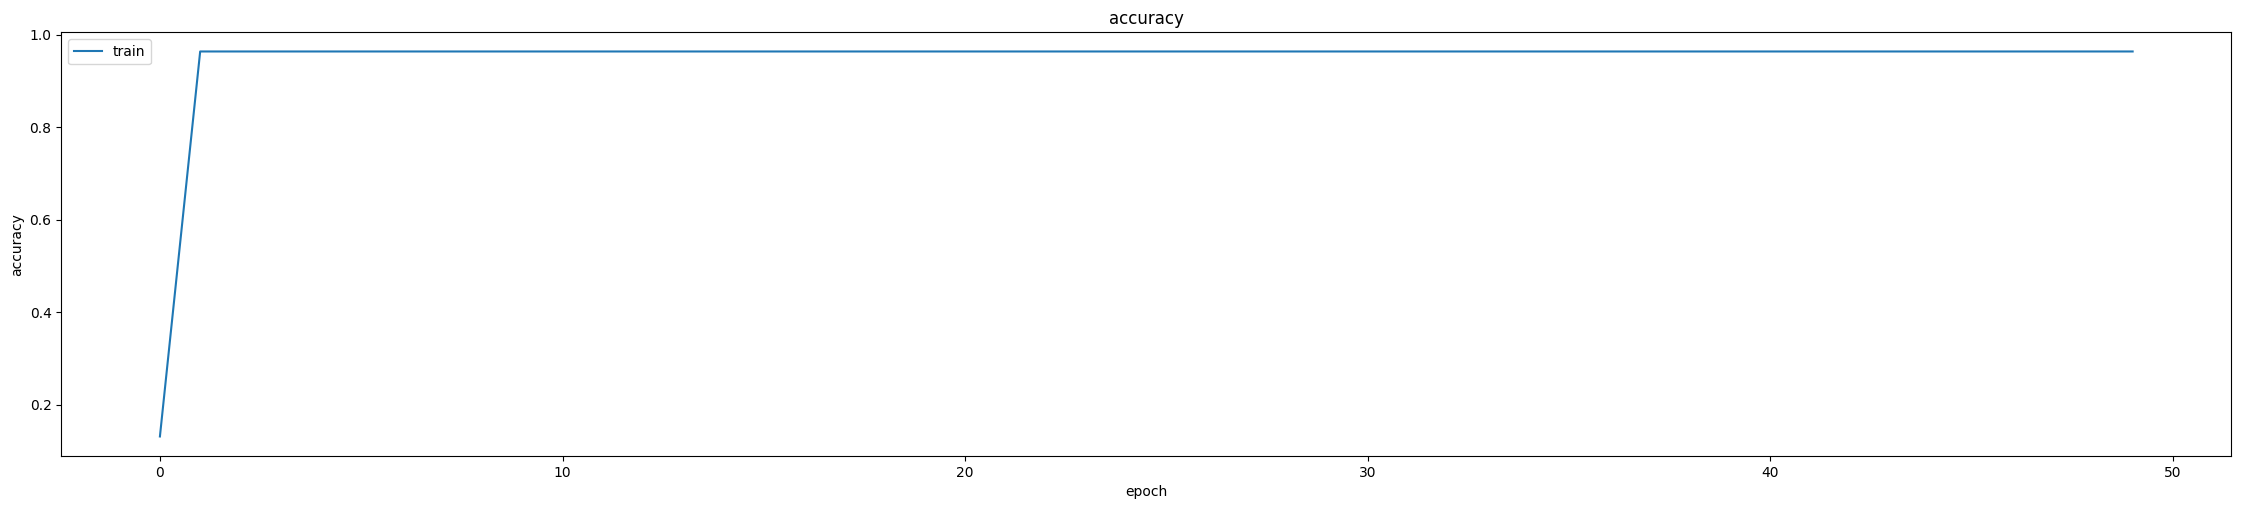

,loss,accuracy
0,0.131955,0.963667
1,0.132087,0.963667
2,0.132265,0.963667
3,0.134509,0.963667
4,0.135079,0.963667


In [66]:
def plotHistory(history):
        plt.plot(history.history['accuracy'])
        plt.title('accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

print ("Train the model")
length=len(X_train_LSTM)
path_to_file="/content/drive/MyDrive/Imperial College Data Science/Portfolio Project/Model Weights/model_LSTM/bayes_model2.h5"

early_stopping = EarlyStopping(monitor='accuracy', patience=50)
file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
X2 = np.asarray(X_train_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y2 = np.asarray(y_train_LSTM_1).astype(np.float32)
#history=model.fit(X2,y2,batch_size=len(X),epochs=100,verbose=1,callbacks=[early_stopping])
history=model.fit(X2,y2,batch_size=len(X_train_LSTM),epochs=50,verbose=1)
model.save_weights(path_to_file) # can give whole path to save model
plotHistory(history)

# make a dataframe losses and accuracies
history_df = pd.DataFrame(history.history)

#show the top 5 accuracies
history_df.sort_values('loss', ascending = True, inplace = True)
history_df.reset_index(inplace = True, drop = True)
history_df.head()

In [67]:
# calculate the roc_auc score
X2 = np.asarray(X_train_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_bayesian_train = roc_auc_score(y_train_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the train set for bayesian optimised LSTM network", auc_bayesian_train)

auc_bayesian_train = pd.Series(auc_bayesian_train)

188/188 [==============================] - 3s 9ms/step
The AUC of the train set for bayesian optimised LSTM network 0.8793459772339972


In [68]:
# calculate the roc_auc score
X2 = np.asarray(X_val_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_bayesian_val = roc_auc_score(y_val_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the validation set for bayesian optimised LSTM network", auc_bayesian_val)

auc_bayesian_val = pd.Series(auc_bayesian_val)

63/63 [==============================] - 0s 4ms/step
The AUC of the validation set for bayesian optimised LSTM network 0.8809621993127148


In [69]:
# calculate the roc_auc score
X2 = np.asarray(X_test_LSTM).astype(np.float32)
X2 = np.resize(X2,(X2.shape[0],1,X2.shape[1]))
y_pred=model.predict(X2)

auc_bayesian_test = roc_auc_score(y_test_LSTM_1, y_pred,multi_class="ovr")
print("The AUC of the test set for bayesian optimised LSTM network", auc_bayesian_test)

auc_bayesian_test = pd.Series(auc_bayesian_test)

63/63 [==============================] - 0s 5ms/step
The AUC of the test set for bayesian optimised LSTM network 0.8747918058150643


### Build the Logistic Regression Model

In [70]:
#Create a dataframe for the logistic regression
df1 = data.copy()
df1

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [71]:
# defining X and Y variables
X = df1.drop(["Machine failure","UDI", "Product ID", "Type", "Air temperature [K]", "Torque [Nm]"], axis=1)
Y = df1["Machine failure"]

# adding a constant to the independent variables
X = sm.add_constant(X)

# creating dummy variables
X = pd.get_dummies(X, drop_first=True)

# splitting data in train_val and test sets in 85:15 ratio
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=1)

# splitting data in train_val set in 70:30 ratio to result in a ~ 60:25:15 overall.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.30, random_state=1)


In [72]:
# Print the quantity and percentage of the entries in each of the dataset.
#print("Shape of Training set : ", X_train.shape)
#print("Shape of Validation set : ", X_val.shape)
#print("Shape of test set : ", X_test.shape)
#print("Percentage of classes in training set:")
#print(y_train.value_counts(normalize=True))
#print("Percentage of classes in validation set:")
#print(y_val.value_counts(normalize=True))
#print("Percentage of classes in test set:")
#print(y_test.value_counts(normalize=True))

#### Build and fit the logistic regression model.

In [73]:
# define the model
#model = LogisticRegression()
## train the model
#lg = model.fit(X_train, y_train)
#lg

In [74]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn


def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [75]:
# defining a function to plot the confusion_matrix of a classification model
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [76]:
# Determine the confusion matrix of the model on the train set
#confusion_matrix_sklearn(lg, X_train, y_train)

In [77]:
# Check the performance of the training model
#print("Training performance:")
#logistic_train = model_performance_classification_sklearn(lg, X_train, y_train)
#logistic_train

In [78]:
# Determine the confusion matrix of the model on the train set
#confusion_matrix_sklearn(lg, X_val, y_val)

In [79]:
# Check the performance of the validation model
#print("Validation performance:")
#logistic_val = model_performance_classification_sklearn(lg, X_val, y_val)
#logistic_val

In [80]:
# Check the performance of the training model
#print("Test performance:")
#logistic_test = model_performance_classification_sklearn(lg, X_test, y_test)
#logistic_test

Observations:
- The model seems to be performing very well even though the test data is imbalanced. The model performs better on the test data than the train and validation set.
- Other models will be built to see how they perform on the data.
- Although the F1 score drops in the validation set it increase shows a perfect score in the test set.

### Build the Decision Tree Model

#### Original Dataset

In [81]:
# Fit the decision tree on the original data
dtree_model = DecisionTreeClassifier(criterion='gini',random_state=1)
dtree_model.fit(X_train_LSTM, y_train_LSTM)

DecisionTreeClassifier(random_state=1)

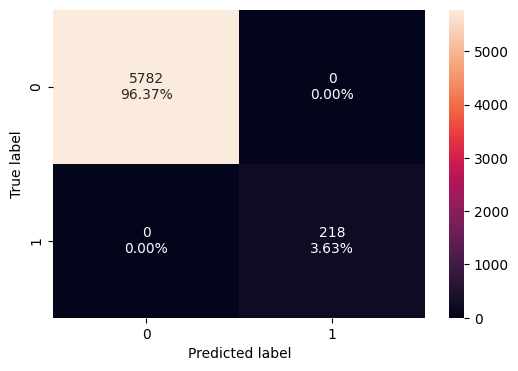

In [82]:
# Determine the original data confusion matrix of the decision tree model on the training set
confusion_matrix_sklearn(dtree_model, X_train_LSTM, y_train_LSTM)

In [83]:
# Check the performance of original data decision tree model on the training set
dtree_model_train_perf=model_performance_classification_sklearn(dtree_model, X_train_LSTM, y_train_LSTM)
print("Training performance on the original data:")
dtree_model_train_perf

Training performance on the original data:


,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


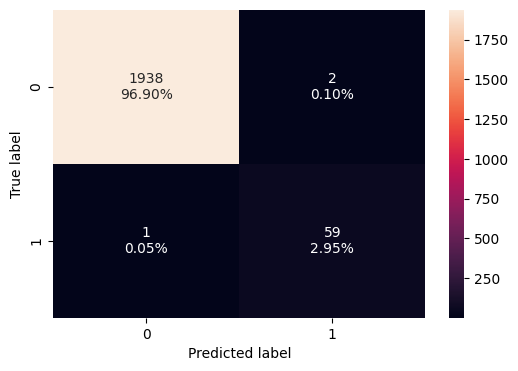

In [84]:
# Determine the original data confusion matrix of the decision tree model on the validation set
confusion_matrix_sklearn(dtree_model, X_val_LSTM, y_val_LSTM)

In [85]:
# Check the performance of original data decision tree model on the validation set
dtree_model_val_perf=model_performance_classification_sklearn(dtree_model, X_val_LSTM, y_val_LSTM)
print("Validation performance on the original data:")
dtree_model_val_perf

Validation performance on the original data:


,Accuracy,Recall,Precision,F1
0,0.9985,0.983333,0.967213,0.975207


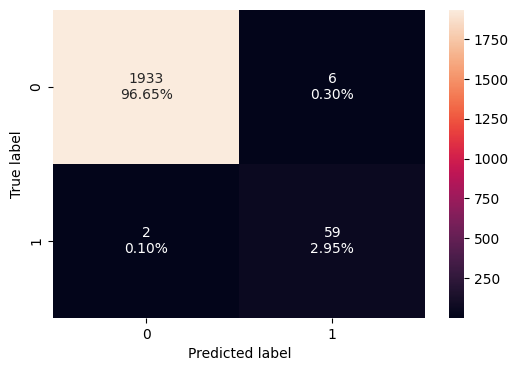

In [86]:
# Determine the original data confusion matrix of the decision tree model on test set
confusion_matrix_sklearn(dtree_model, X_test_LSTM, y_test_LSTM)

In [87]:
# Check the performance of original data decision tree model on the test set
dtree_model_test_perf=model_performance_classification_sklearn(dtree_model, X_test_LSTM, y_test_LSTM)
print("Test performance on the original data:")
dtree_model_test_perf

Test performance on the original data:


,Accuracy,Recall,Precision,F1
0,0.996,0.967213,0.907692,0.936508


Observations:
- The model trained on the original data performs well but the data is imbalanced. From the confusion matrix, the model classifies all the classes correctly in the training dataset but misclassifies 3 observations in the validation set.

#### Undersampled Dataset

In [88]:
# Fit the decision tree on the underesampled data
dtree_model_un = DecisionTreeClassifier(criterion='gini',random_state=1)
dtree_model_un.fit(X_train_LSTM_un, y_train_LSTM_un)

DecisionTreeClassifier(random_state=1)

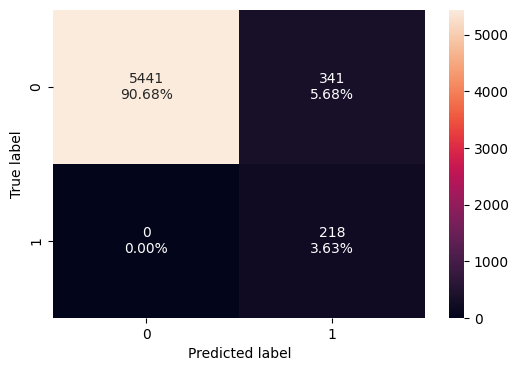

In [89]:
# show the undersampled data confusion matrix of the decision tree model on the training set
confusion_matrix_sklearn(dtree_model_un, X_train_LSTM, y_train_LSTM)

In [90]:
# Check the performance of undersampled data decision tree model on the training set
dtree_model_train_un_perf=model_performance_classification_sklearn(dtree_model_un, X_train_LSTM, y_train_LSTM)
print("Training performance on the undersampled data:")
dtree_model_train_un_perf

Training performance on the undersampled data:


,Accuracy,Recall,Precision,F1
0,0.943167,1.0,0.389982,0.561133


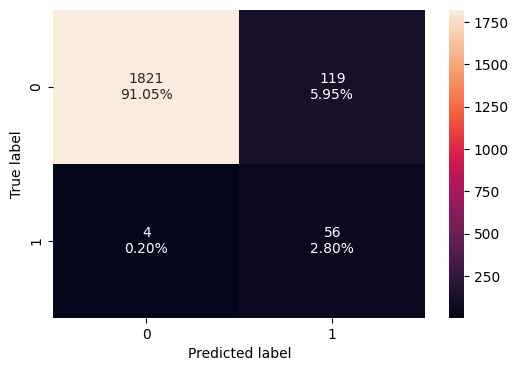

In [91]:
# show the undersampled data confusion matrix of the decision tree model on the validation set
confusion_matrix_sklearn(dtree_model_un, X_val_LSTM, y_val_LSTM)

In [92]:
# Check the performance of the undersampled data decision tree model on the validation set
dtree_model_val_un_perf=model_performance_classification_sklearn(dtree_model_un, X_val_LSTM, y_val_LSTM)
print("Validation performance on the undersampled data:")
dtree_model_val_un_perf

Validation performance on the undersampled data:


,Accuracy,Recall,Precision,F1
0,0.9385,0.933333,0.32,0.476596


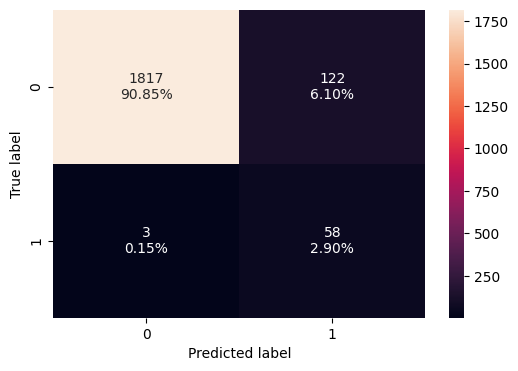

In [93]:
# show the undersampled data confusion matrix of the decision tree model on the validation set
confusion_matrix_sklearn(dtree_model_un, X_test_LSTM, y_test_LSTM)

In [94]:
# Check the performance of the undersampled data decision tree model on the validation set
dtree_model_test_un_perf=model_performance_classification_sklearn(dtree_model_un, X_test_LSTM, y_test_LSTM)
print("Test performance on the undersampled data:")
dtree_model_test_un_perf

Test performance on the undersampled data:


,Accuracy,Recall,Precision,F1
0,0.9375,0.95082,0.322222,0.481328


Observations:
- The decision tree model trained on the original dataset performs well on the performance metric.


#### Oversampled Dataset

In [95]:
# Fit the decision tree on the oversampled dataset
dtree_model_ov = DecisionTreeClassifier(criterion='gini',random_state=1)
dtree_model_ov.fit(X_train_LSTM_ov, y_train_LSTM_ov)

DecisionTreeClassifier(random_state=1)

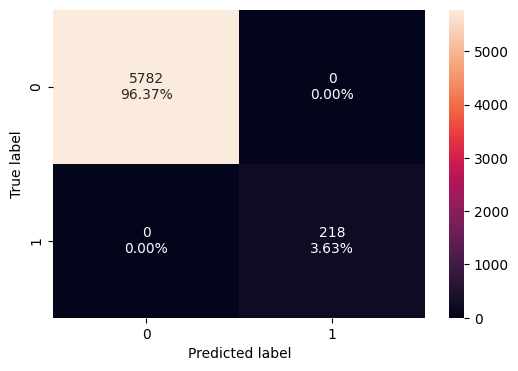

In [96]:
# show the oversampled data confusion matrix of the train set
confusion_matrix_sklearn(dtree_model_ov, X_train_LSTM, y_train_LSTM)


In [97]:
# Check the performance of oversampled data decision tree model on the train set
dtree_model_train_ov_perf=model_performance_classification_sklearn(dtree_model_ov, X_train_LSTM, y_train_LSTM)
print("Training performance:")
dtree_model_train_ov_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


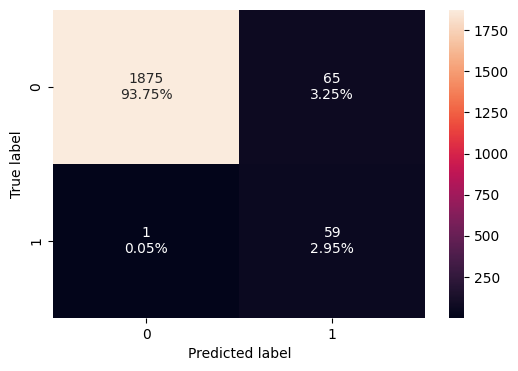

In [98]:
# show the oversampled data confusion matrix of the validation set
confusion_matrix_sklearn(dtree_model_ov, X_val_LSTM, y_val_LSTM)

In [99]:
# Check the performance of oversampled data decision tree model on the validation set
dtree_model_val_ov_perf=model_performance_classification_sklearn(dtree_model_ov, X_val_LSTM, y_val_LSTM)
print("Validation performance:")
dtree_model_val_ov_perf

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.983333,0.475806,0.641304


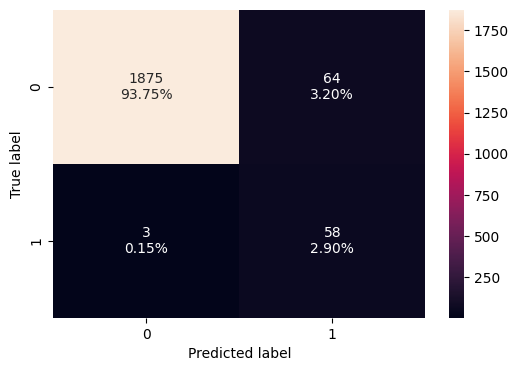

In [100]:
# show the oversampled data confusion matrix of the validation set
confusion_matrix_sklearn(dtree_model_ov, X_test_LSTM, y_test_LSTM)

In [101]:
# Check the performance of oversampled data decision tree model on the validation set
dtree_model_test_ov_perf=model_performance_classification_sklearn(dtree_model_ov, X_test_LSTM, y_test_LSTM)
print("Test performance:")
dtree_model_test_ov_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.9665,0.95082,0.47541,0.63388


### Hyperparameter Tuning on the Validation Set - Random and Grid Search

#### Random Search

In [102]:
#check the cost complexities to determine a range of values
clf_ov = DecisionTreeClassifier()
clf_ov.fit(X_train_LSTM_ov, y_train_LSTM_ov)
path = clf_ov.cost_complexity_pruning_path(X_train_LSTM_ov, y_train_LSTM_ov)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

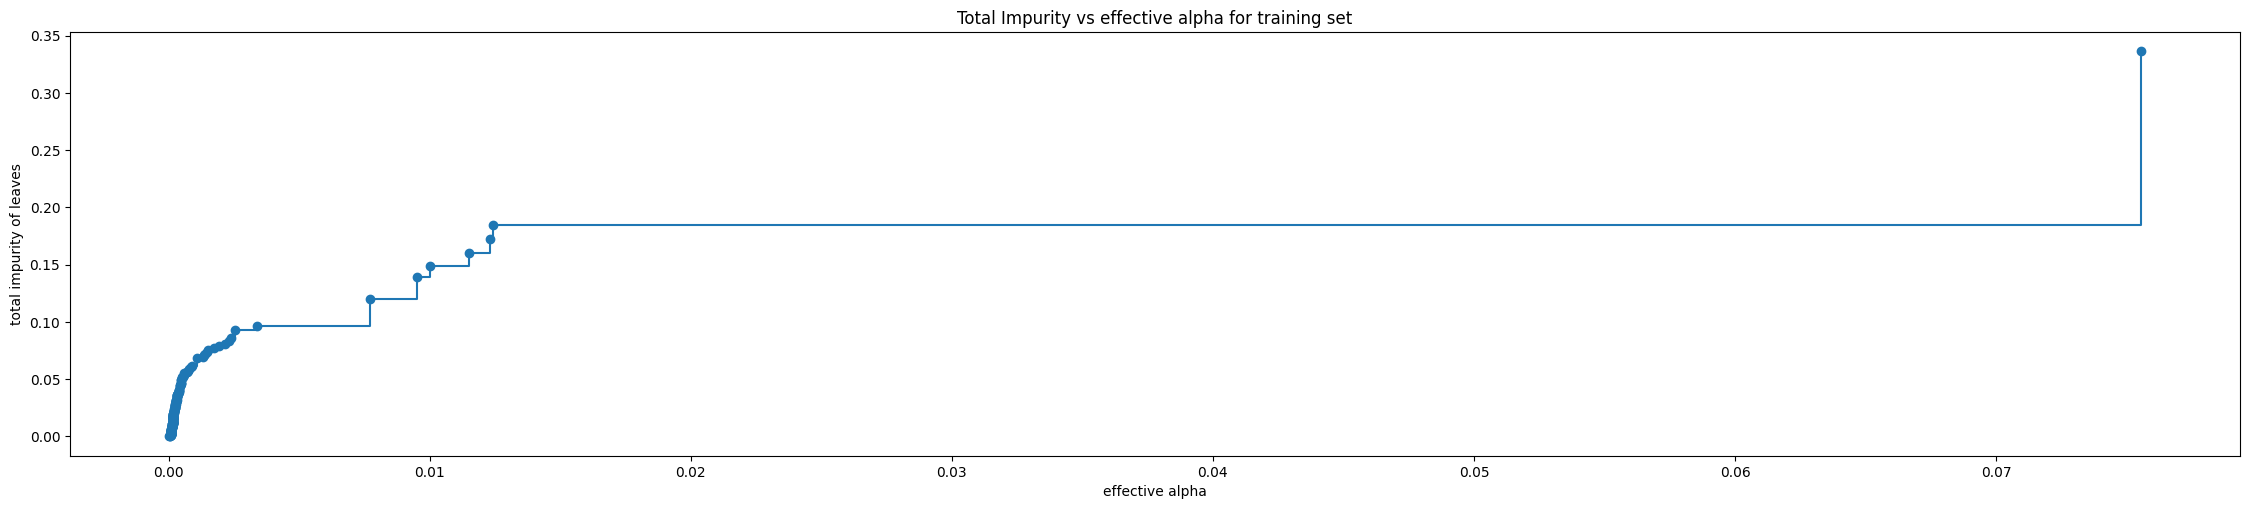

In [103]:
#plot the total impurities of leaves against the effective alphas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

plt.show()


In [104]:
# check all the available hyperparameters in a decision tree model.
clf = DecisionTreeClassifier()
print(clf.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [105]:
# Hyperparameter grid
param_grid = {
    'ccp_alpha': list(np.linspace(0.0,0.1,num=11)),
    'class_weight': [None, 'balanced'],
    'criterion': ['gini','entropy'],
    'max_depth': [None,5,10,15,20],
    'max_features': [None,'sqrt','log2'],
    'max_leaf_nodes': [None,10,20,30],
    'min_impurity_decrease': [0.0,0.1,0.2],
    'min_samples_leaf': [15,25],
    'min_samples_split': [2,3,4],
    'min_weight_fraction_leaf': [0.0,0.1,0.2],
    'random_state': [50],
    'splitter': ['best', 'random']

}

In [106]:
# Randomly sample parameters for gbm
#params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
#params

In [107]:
# conduct oversampling on the dataset
print("Before OverSampling, counts of label '1': {}".format(sum(y_val == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_val == 0)))

# Initialize SMOTE
smote = SMOTE()

# Fit SMOTE on the training data
X_val_clf_ov, y_val_clf_ov = smote.fit_resample(X_val, y_val)

print("After OverSampling, counts of label '1': {}".format(sum(y_val_clf_ov == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_val_clf_ov == 0)))


print("After OverSampling, the shape of X_val: {}".format(X_val_clf_ov.shape))
print("After OverSampling, the shape of y_val: {} \n".format(y_val_clf_ov.shape))

Before OverSampling, counts of label '1': 98
Before OverSampling, counts of label '0': 2452 

After OverSampling, counts of label '1': 2452
After OverSampling, counts of label '0': 2452 

After OverSampling, the shape of X_val: (4904, 9)
After OverSampling, the shape of y_val: (4904,) 



In [131]:
#from timeit import default_timer as timer

#def randomized_search_cv(clf, param_grid, X, y, cv=10):
    # Initialize RandomizedSearchCV
    # random_search = RandomizedSearchCV(clf, param_grid, cv=cv, return_train_score=True)

    # Fit RandomizedSearchCV and time it
    #start = timer()
    #random_search.fit(X, y)
    #end = timer()

    # Create a DataFrame from cv_results_
    #results_df = pd.DataFrame(random_search.cv_results_)

    # Add a column for the total training time
    #results_df['total_training_time'] = end - start

    #print(f"Total training time: {end - start} seconds")

    #return results_df

#results_df = randomized_search_cv(clf, param_grid,X_val_clf_ov, y_val_clf_ov)



In [132]:
# conduct the random search on the hyperparameters using the validation set environment.
from timeit import default_timer as timer

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

start = timer()
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_grid, scoring=scorer, cv=5)

# Fit RandomizedSearchCV
random_search = random_search.fit(X_val_clf_ov, y_val_clf_ov)

end = timer()

# Set the clf to the best combination of parameters
dtree_rand_search = random_search.best_estimator_

# Fit the best algorithm to the data.
dtree_rand_search.fit(X_val_clf_ov, y_val_clf_ov)

print("Best F1 Score: ", random_search.best_score_)

print(f"Total training time: {end - start} seconds")

print("Best Parameters: ", random_search.best_params_)


Best F1 Score:  0.8356214372071588
Total training time: 0.8401492980001422 seconds
Best Parameters:  {'splitter': 'best', 'random_state': 50, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 3, 'min_samples_leaf': 25, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 10, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.06}


In [133]:
#results_df.sort_values(by='mean_train_score', ascending=False).head(1)

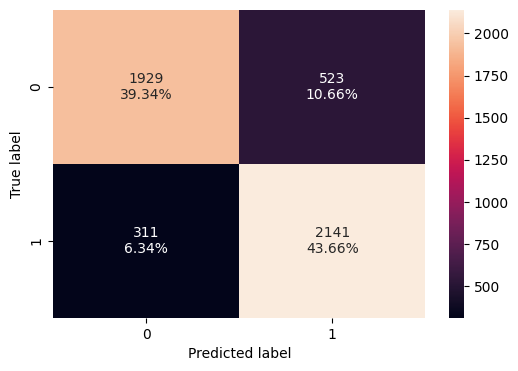

In [134]:
# plot the confusion matrix of the validation set
confusion_matrix_sklearn(dtree_rand_search, X_val_clf_ov, y_val_clf_ov)

In [135]:
# Check the performance of decision tree model on the validation set
dtree_rand_search_val_perf=model_performance_classification_sklearn(dtree_rand_search, X_val_clf_ov, y_val_clf_ov)
print("Tuned decision tree performance on the validation set :")
dtree_rand_search_val_perf

Tuned decision tree performance on the validation set :


,Accuracy,Recall,Precision,F1
0,0.829935,0.873165,0.803679,0.836982


In [136]:
# Make predictions on the test set
# y_pred = dtree_rand_search.predict(X_test)

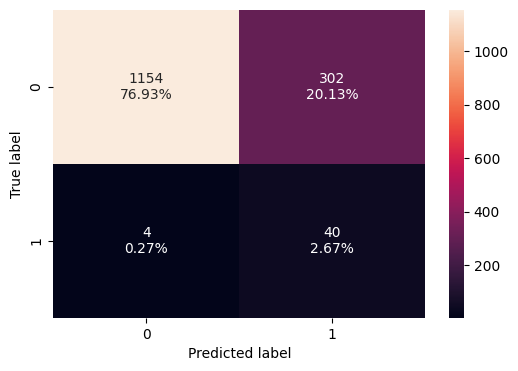

In [137]:
# plot the confusion matrix of the test set
confusion_matrix_sklearn(dtree_rand_search, X_test, y_test)

In [138]:
# Check the performance of decision tree model on the test set
dtree_rand_search_test_perf=model_performance_classification_sklearn(dtree_rand_search, X_test, y_test)
print("Tuned decision tree performance on the test set :")
dtree_rand_search_test_perf

Tuned decision tree performance on the test set :


,Accuracy,Recall,Precision,F1
0,0.796,0.909091,0.116959,0.207254


#### Grid Search

In [154]:
# Tune the decision tree model (oversampled data).
dtree_model_ov_estimator = DecisionTreeClassifier(class_weight="balanced", random_state=1)

# Grid of parameters to choose from
parameters = {
    "criterion": ['gini', 'entropy'],
    "max_depth": np.arange(10, 20, 5),
    "min_samples_leaf": [3, 5, 7],
    "max_leaf_nodes": [2, 5],
    "min_samples_split": [10, 20, 30],
    "min_impurity_decrease": [0.0001, 0.001],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_model_ov_estimator, parameters, scoring=scorer, cv=5)
grid_obj = grid_obj.fit(X_train_LSTM_ov, y_train_LSTM_ov)

# Set the clf to the best combination of parameters
dtree_model_ov_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
dtree_model_ov_estimator.fit(X_train_LSTM_ov, y_train_LSTM_ov)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_leaf_nodes=5,
                       min_impurity_decrease=0.0001, min_samples_leaf=3,
                       min_samples_split=10, random_state=1)

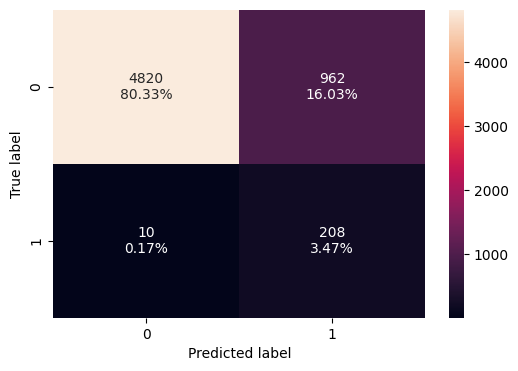

In [155]:
# Determine the confusion matrix of the tuned decision tree model on the training set
confusion_matrix_sklearn(dtree_model_ov_estimator, X_train_LSTM, y_train_LSTM)

In [156]:
# Check the performance of decision tree model on the train set
dtree_model_ov_estimator_train_perf=model_performance_classification_sklearn(dtree_model_ov_estimator, X_train_LSTM, y_train_LSTM)
print("Tuned decision tree performance on the oversampled train set :")
dtree_model_ov_estimator_train_perf

Tuned decision tree performance on the oversampled train set :


,Accuracy,Recall,Precision,F1
0,0.838,0.954128,0.177778,0.299712


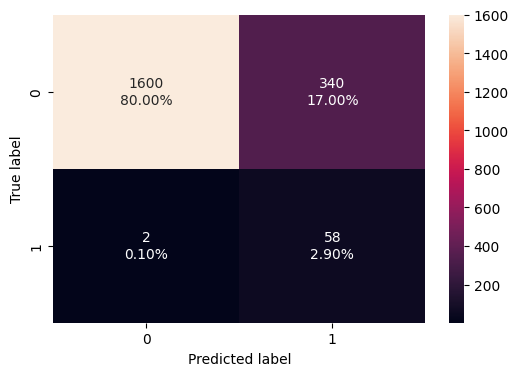

In [157]:
# show the oversampled data confusion matrix of the validation set
confusion_matrix_sklearn(dtree_model_ov_estimator, X_val_LSTM, y_val_LSTM)

In [158]:
# Check the performance of decision tree model on the validation set
dtree_model_ov_estimator_val_perf=model_performance_classification_sklearn(dtree_model_ov_estimator, X_val_LSTM, y_val_LSTM)
print("Tuned decision tree performance on the oversampled validation set :")
dtree_model_ov_estimator_val_perf

Tuned decision tree performance on the oversampled validation set :


,Accuracy,Recall,Precision,F1
0,0.829,0.966667,0.145729,0.253275


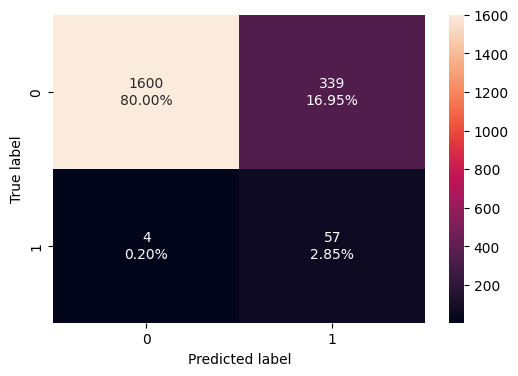

In [159]:
# show the oversampled data confusion matrix of the validation set
confusion_matrix_sklearn(dtree_model_ov_estimator, X_test_LSTM, y_test_LSTM)

In [160]:
# Check the performance of decision tree model on the validation set
dtree_model_ov_estimator_test_perf=model_performance_classification_sklearn(dtree_model_ov_estimator, X_test_LSTM, y_test_LSTM)
print("Tuned decision tree performance on the oversampled test set :")
dtree_model_ov_estimator_test_perf

Tuned decision tree performance on the oversampled test set :


,Accuracy,Recall,Precision,F1
0,0.8285,0.934426,0.143939,0.249453


### Model Comparison

In [161]:
# LSTM Neutral Network performance comparison

models_LSTM_comp_df = pd.concat(
    [
        auc_original_train_data.T,
        auc_original_val_data.T,
        auc_original_test_data.T,
        auc_undersampled_train_data.T,
        auc_undersampled_val_data.T,
        auc_undersampled_test_data.T,
        auc_oversampled_train_data.T,
        auc_oversampled_val_data.T,
        auc_oversampled_test_data.T
    ],
    axis=1,
)
models_LSTM_comp_df.columns = [
    "AUC Perf. Original Train Data",
    "AUC Perf. Original Val. Data",
    "AUC Perf. Original Test Data",
    "AUC Perf. Undersampled Train Data",
    "AUC Perf. Undersampled Val. Data",
    "AUC Perf. Undersampled Test Data",
    "AUC Perf. Oversampled Train Data",
    "AUC Perf. Oversampled Val. Data",
    "AUC Perf. Oversampled Test Data"
]
print("LSTM Neural Network Performance Comparison:")
models_LSTM_comp_df

LSTM Neural Network Performance Comparison:


,AUC Perf. Original Train Data,AUC Perf. Original Val. Data,AUC Perf. Original Test Data,AUC Perf. Undersampled Train Data,AUC Perf. Undersampled Val. Data,AUC Perf. Undersampled Test Data,AUC Perf. Oversampled Train Data,AUC Perf. Oversampled Val. Data,AUC Perf. Oversampled Test Data
0,0.991556,0.995438,0.985674,0.994155,0.996198,0.982765,0.990002,0.989957,0.979261


In [162]:
# Bayesian Optimisation
models_Bayes_LSTM_comp_df = pd.concat(
    [
        auc_bayesian_train.T,
        auc_bayesian_val.T,
        auc_bayesian_test.T,
    ],
    axis=1,
)
models_Bayes_LSTM_comp_df.columns = [
    "AUC Perf. Bayes Train Data",
    "AUC Perf. Bayes Val. Data",
    "AUC Perf. Bayes Test Data",
]
print("Bayesian Optimisation LSTM Comparison")
models_Bayes_LSTM_comp_df

Bayesian Optimisation LSTM Comparison


,AUC Perf. Bayes Train Data,AUC Perf. Bayes Val. Data,AUC Perf. Bayes Test Data
0,0.879346,0.880962,0.874792


In [163]:
# Decision Tree Performance Comparison

models_decision_tree_comp_df = pd.concat(
    [
        dtree_model_train_perf.T,
        dtree_model_val_perf.T,
        dtree_model_test_perf.T,
        dtree_model_train_un_perf.T,
        dtree_model_val_un_perf.T,
        dtree_model_test_un_perf.T,
        dtree_model_train_ov_perf.T,
        dtree_model_val_ov_perf.T,
        dtree_model_test_ov_perf.T
    ],
    axis=1,
)
models_decision_tree_comp_df.columns = [
    "DTree Perf. Original Train Data",
    "DTree Perf. Original Val. Data",
    "DTree Perf. Original Test Data",
    "DTree Perf. Undersampled Train Data",
    "DTree Perf. Undersampled Val. Data",
    "DTree Perf. Undersampled Test Data",
    "DTree Perf. Oversampled Train Data",
    "DTree Perf. Oversampled Val. Data",
    "DTree Perf. Oversampled Test Data"
]
print("Decision Tree Performance Comparison:")
models_decision_tree_comp_df

Decision Tree Performance Comparison:


,DTree Perf. Original Train Data,DTree Perf. Original Val. Data,DTree Perf. Original Test Data,DTree Perf. Undersampled Train Data,DTree Perf. Undersampled Val. Data,DTree Perf. Undersampled Test Data,DTree Perf. Oversampled Train Data,DTree Perf. Oversampled Val. Data,DTree Perf. Oversampled Test Data
Accuracy,1.0,0.998500,0.996000,0.943167,0.938500,0.937500,1.0,0.967000,0.96650
Recall,1.0,0.983333,0.967213,1.000000,0.933333,0.950820,1.0,0.983333,0.95082
Precision,1.0,0.967213,0.907692,0.389982,0.320000,0.322222,1.0,0.475806,0.47541
F1,1.0,0.975207,0.936508,0.561133,0.476596,0.481328,1.0,0.641304,0.63388


In [164]:
# Random-Search-Tuned Decision Tree Performance Comparison

models_decision_tree_comp_df = pd.concat(
    [
        dtree_rand_search_val_perf.T,
        dtree_rand_search_test_perf.T,
    ],
    axis=1,
)
models_decision_tree_comp_df.columns = [
    "Tuned DTree Perf. Original Val. Data",
    "Tuned DTree Perf. Original Test Data",
]
print("Random-Search-Tuned Decision Tree Performance Comparison:")
models_decision_tree_comp_df

Random-Search-Tuned Decision Tree Performance Comparison:


,Tuned DTree Perf. Original Val. Data,Tuned DTree Perf. Original Test Data
Accuracy,0.829935,0.796000
Recall,0.873165,0.909091
Precision,0.803679,0.116959
F1,0.836982,0.207254


In [171]:
# Grid-Search-Tuned Decision Tree Performance Comparison
models_decision_tree_comp_df = pd.concat(
    [
        dtree_model_ov_estimator_train_perf.T,
        dtree_model_ov_estimator_val_perf.T,
        dtree_model_ov_estimator_test_perf.T,
    ],
    axis=1,
)
models_decision_tree_comp_df.columns = [
    "Tuned DTree Perf. Original Train Data",
    "Tuned DTree Perf. Original Val. Data",
    "Tuned DTree Perf. Original Test Data",
]
print("Grid-Search-Tuned Decision Tree Performance Comparison:")
models_decision_tree_comp_df

Grid-Search-Tuned Decision Tree Performance Comparison:


,Tuned DTree Perf. Original Train Data,Tuned DTree Perf. Original Val. Data,Tuned DTree Perf. Original Test Data
Accuracy,0.838000,0.829000,0.828500
Recall,0.954128,0.966667,0.934426
Precision,0.177778,0.145729,0.143939
F1,0.299712,0.253275,0.249453


In [172]:
#print("LSTM Neural Network Performance Comparison:")
#print(models_LSTM_comp_df)
#print("Decision Tree Performance Comparison:")
#print(models_decision_tree_comp_df)
#print("Grid-Search-Tuned Decision Tree Performance Comparison:")
#print(models_decision_tree_comp_df)
#print("Bayesian Optimisation LSTM Comparison")
#print(models_Bayes_LSTM_comp_df)

### Draw the Decision Tree

In [173]:
# Determine the important features
feature_names = list(X_train_LSTM.columns)
importances = dtree_model_ov_estimator.feature_importances_
indices = np.argsort(importances)

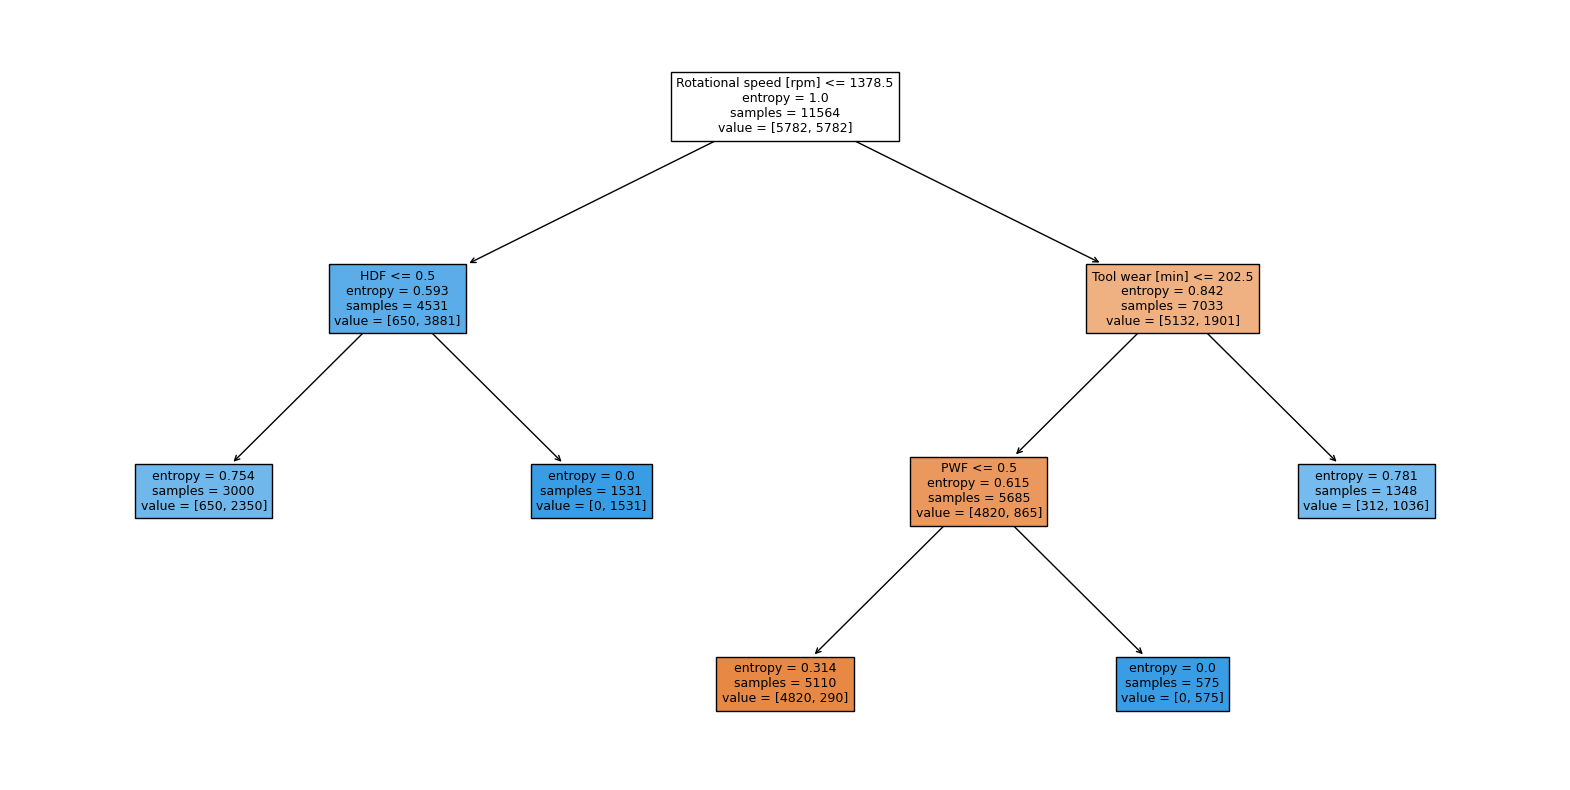

In [174]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
out = tree.plot_tree(
    dtree_model_ov_estimator,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

In [175]:
# Text report showing the rules of the decision tree -
print(tree.export_text(dtree_model_ov_estimator, feature_names=feature_names, show_weights=True))

|--- Rotational speed [rpm] <= 1378.50
|   |--- HDF <= 0.50
|   |   |--- weights: [650.00, 2350.00] class: 1
|   |--- HDF >  0.50
|   |   |--- weights: [0.00, 1531.00] class: 1
|--- Rotational speed [rpm] >  1378.50
|   |--- Tool wear [min] <= 202.50
|   |   |--- PWF <= 0.50
|   |   |   |--- weights: [4820.00, 290.00] class: 0
|   |   |--- PWF >  0.50
|   |   |   |--- weights: [0.00, 575.00] class: 1
|   |--- Tool wear [min] >  202.50
|   |   |--- weights: [312.00, 1036.00] class: 1



## Actionable Insights and Recommendations
- Most of the machine failures are caused by the Heat Dissipation Failure (HDF). Therefore, steps should be taken to control the difference between air and process temperature to prevent the temperature difference from dropping below the set threshold.

- Other failure modes that lead to machine failure include overstrained failure and  power failure while random failure rarely lead to machine failures. The maintenance team should also prevent the causes of overstrained and power failure.

- 60% of the products which the machines work on are high quality products which leads to greater frequency of tool wear. There should be replacement stocks for tools that wear easily.

- The air temperature and process temperature maintain a set range. The machine's running hour should be monitored to investigate how the running hour affects the process temperatures and the appropriate steps taken to prevent machine failure due to high process temperatures. If there are several machines, some machines could be left idle during off-peak production to increase the machines lifecycle.

- The LSTM neural network and decision tree models were applied to the data. All the models worked well on the training data. However, the LSTM seems to perform best on the data even thought it is not easily explainable model.

- All the models performed better before hyperparameter tuning, and before undersampling and oversampling. This most likely because the model learned the prevalent class which is not the class of interest.